# 1 | Imports

In [2]:
from data_classes import LAQNData, HealthData, MetData, IncomeData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.api import tsa
from sklearn.preprocessing import MinMaxScaler

# 2 | Load data

### Load the hourly NO$_2$ data

In [3]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)

### Load the hourly meteorology data

In [4]:
heathrow = MetData("Heathrow")

### Load the daily disposable income data

In [5]:
income = IncomeData()

### Load the daily mortality per capita data

In [6]:
mortality = HealthData()

In [7]:
mortality_df = mortality.read("mortality-scaled")
mortality_df["deaths_per_100k"] = mortality_df["deaths"]*100000

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
mortality_df.shape

(13698, 2)

# 3 | Process data + plots

## Daily data

In [8]:
daily_dates = mortality_df.index

### Resample the hourly NO$_2$ data using a custom date list

Only retain the NO$_2$ data up to the final mortality datapoint:

In [9]:
#daily_NO2_df = NO2.resample_time_and_log(daily_dates)

In [16]:
#daily_NO2_df = NO2.read("laqn-resample")

In [17]:
#daily_NO2_df.shape

### Spatially average the NO$_2$ data for all of London

In [13]:
#NO2_df = NO2.regional_average_and_log()

In [15]:
NO2_df = NO2.read("laqn-regional")

wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
NO2_df.shape

(8401, 1)

In [17]:
NO2_df.index.min()

Timestamp('1996-01-01 00:00:00')

#### Scatter plot mortality vs NO$_2$

In [18]:
NO2_df = NO2_df.join(mortality_df)

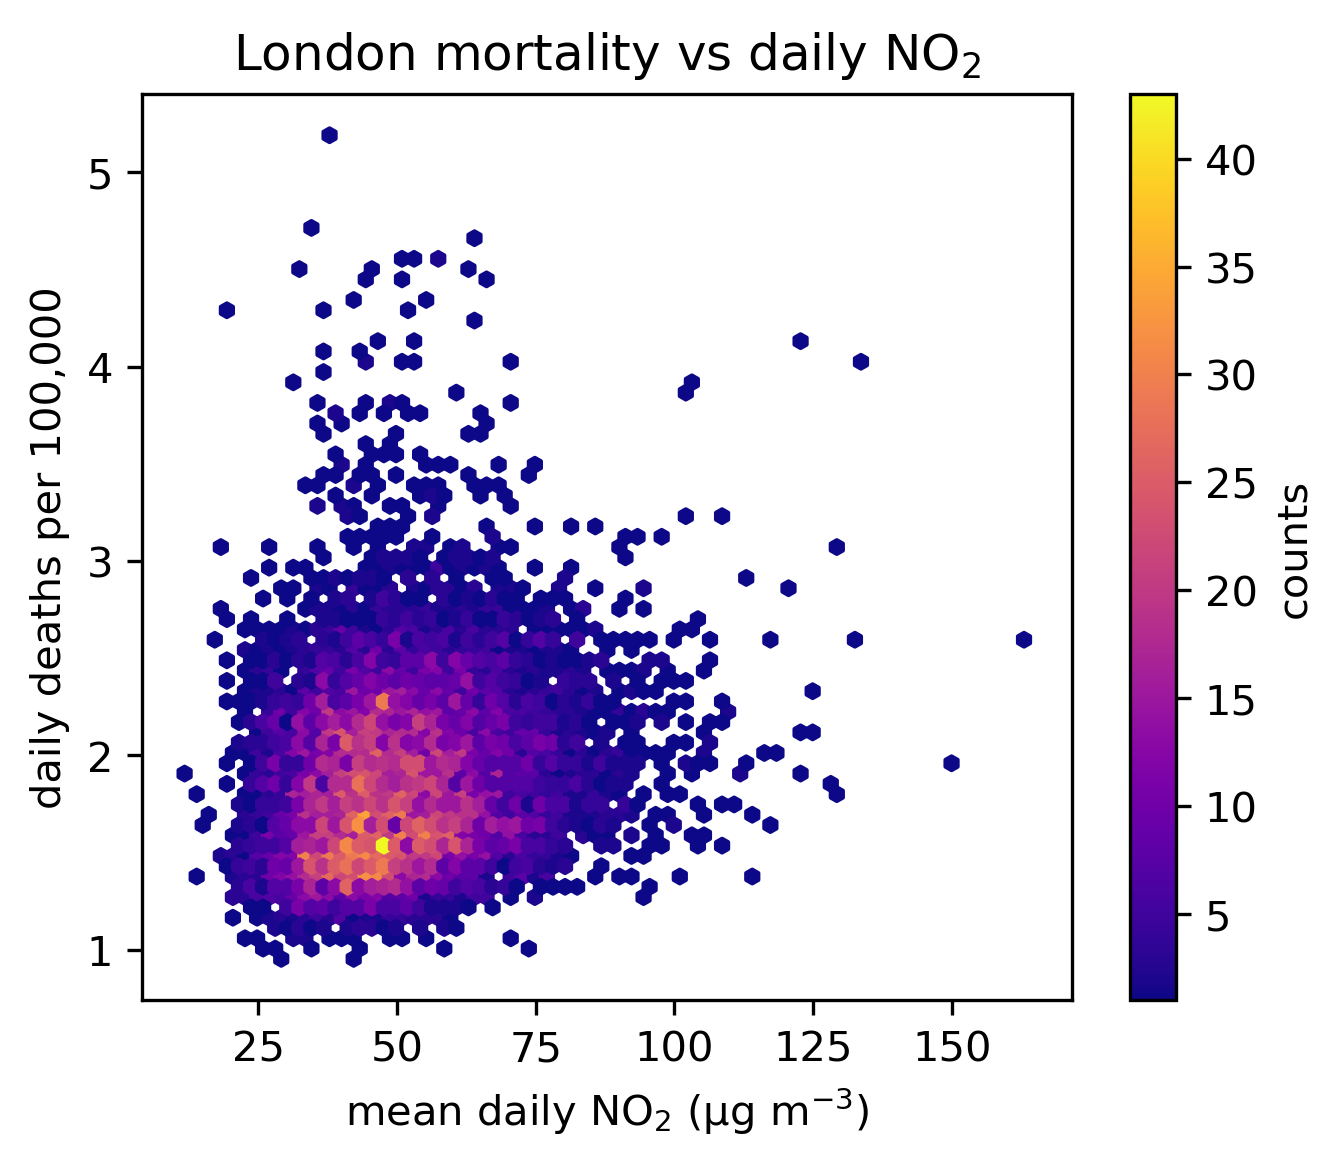

In [31]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(NO2_df.mean_NO2, NO2_df.deaths_per_100k, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.title("London mortality vs daily NO$_2$")
plt.colorbar().set_label("counts")
plt.show()

### Resample the hourly meteorology data using a custom date list

Only retain the met data up to the final mortality datapoint:

In [10]:
#daily_met_df = heathrow.resample_time_and_log(daily_dates)

In [19]:
daily_met_df = heathrow.read(["temperature"], "met-resample")

wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
daily_met_df.shape

(13694, 1)

In [21]:
temperature_df = pd.DataFrame(daily_met_df["temperature"]).join(mortality_df)

## 3.1 | Correlation hexbin plots

In [66]:
def plot_correlation_hexbin(x, y, gridsize, xlabel, ylabel, title):
    plt.figure(figsize=(5,4), dpi=300)
    plt.hexbin(x, y, cmap=cm.plasma, gridsize=gridsize, mincnt=1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.colorbar().set_label("counts")
    plt.show()

#### Scatter plot of mortality vs temperature

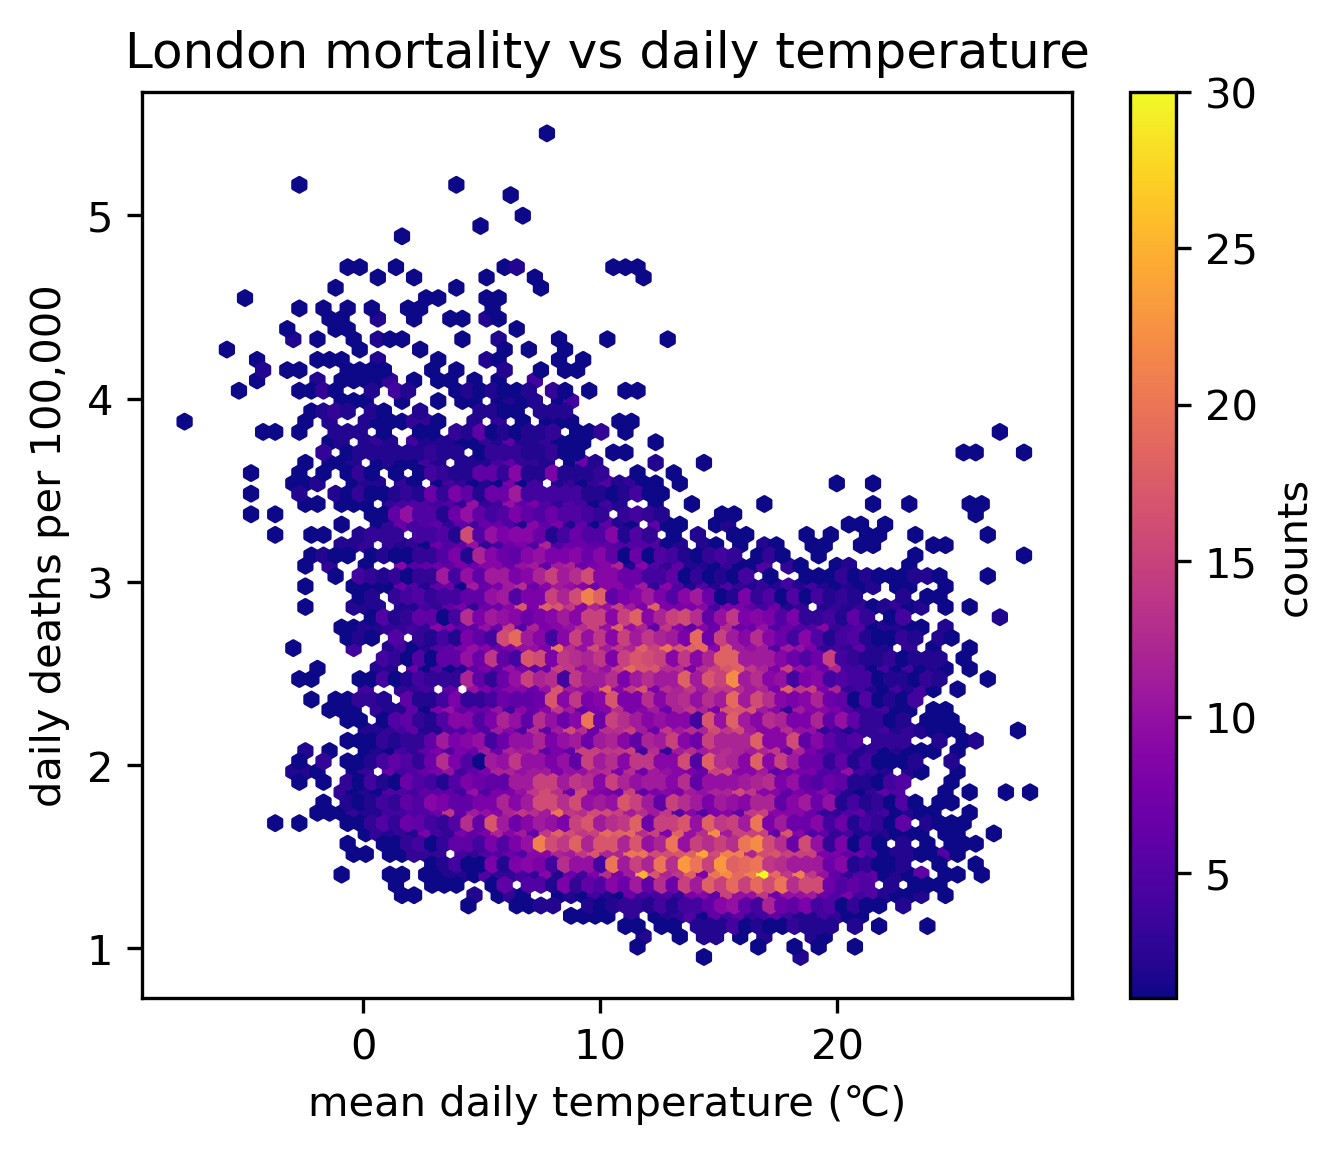

In [37]:
plot_correlation_hexbin(temperature_df.temperature, temperature_df.deaths_per_100k, 
                        gridsize=70, 
                        xlabel="mean daily temperature (℃)", ylabel="daily deaths per 100,000",
                        title="London mortality vs daily temperature")

### Scatter plot of NO$_2$ vs temperature

#### Daily averages

In [22]:
daily_df = pd.DataFrame(NO2_df["mean_NO2"]).join(temperature_df)

In [23]:
daily_df.columns

Index(['mean_NO2', 'temperature', 'deaths', 'deaths_per_100k'], dtype='object')

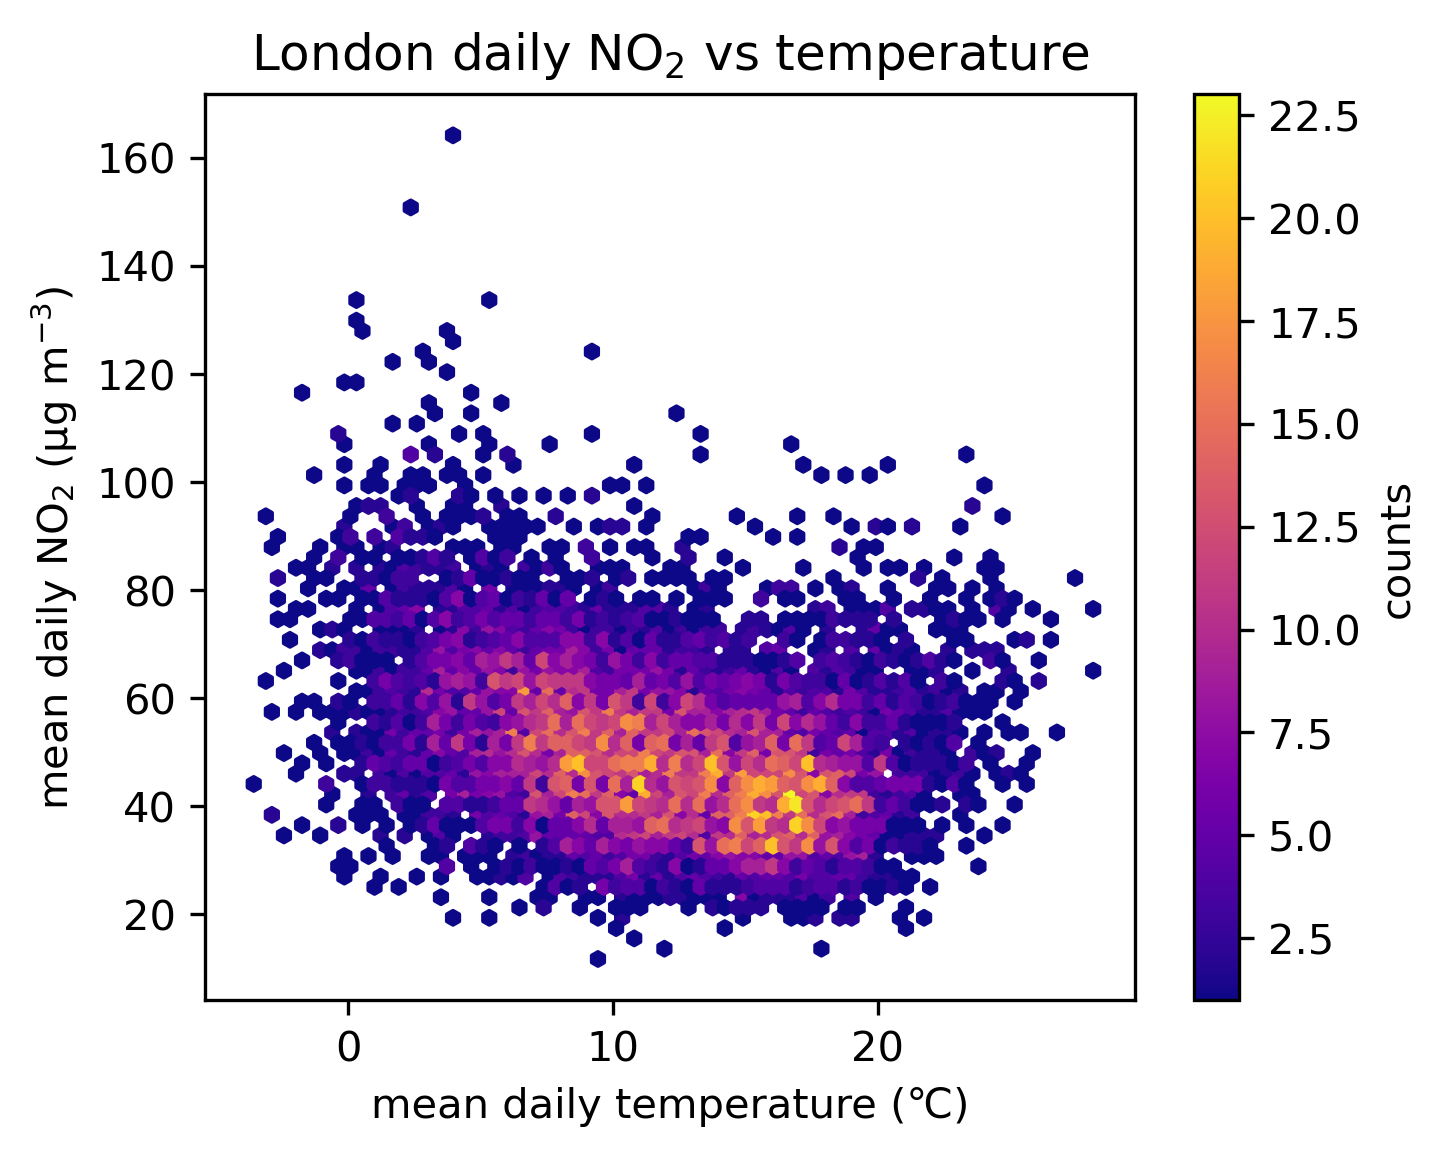

In [38]:
plot_correlation_hexbin(daily_df.temperature, daily_df.mean_NO2, 
                        gridsize=70, 
                        xlabel="mean daily temperature (℃)", ylabel="mean daily NO$_2$ (µg m$^{-3}$)",
                        title="London daily NO$_2$ vs temperature")

### Spatially average the disposable income data for all of London

In [23]:
#income_df = income.regional_average_and_log()

In [24]:
income_df = income.read("income-regional")

wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
income_df.shape

(7671, 1)

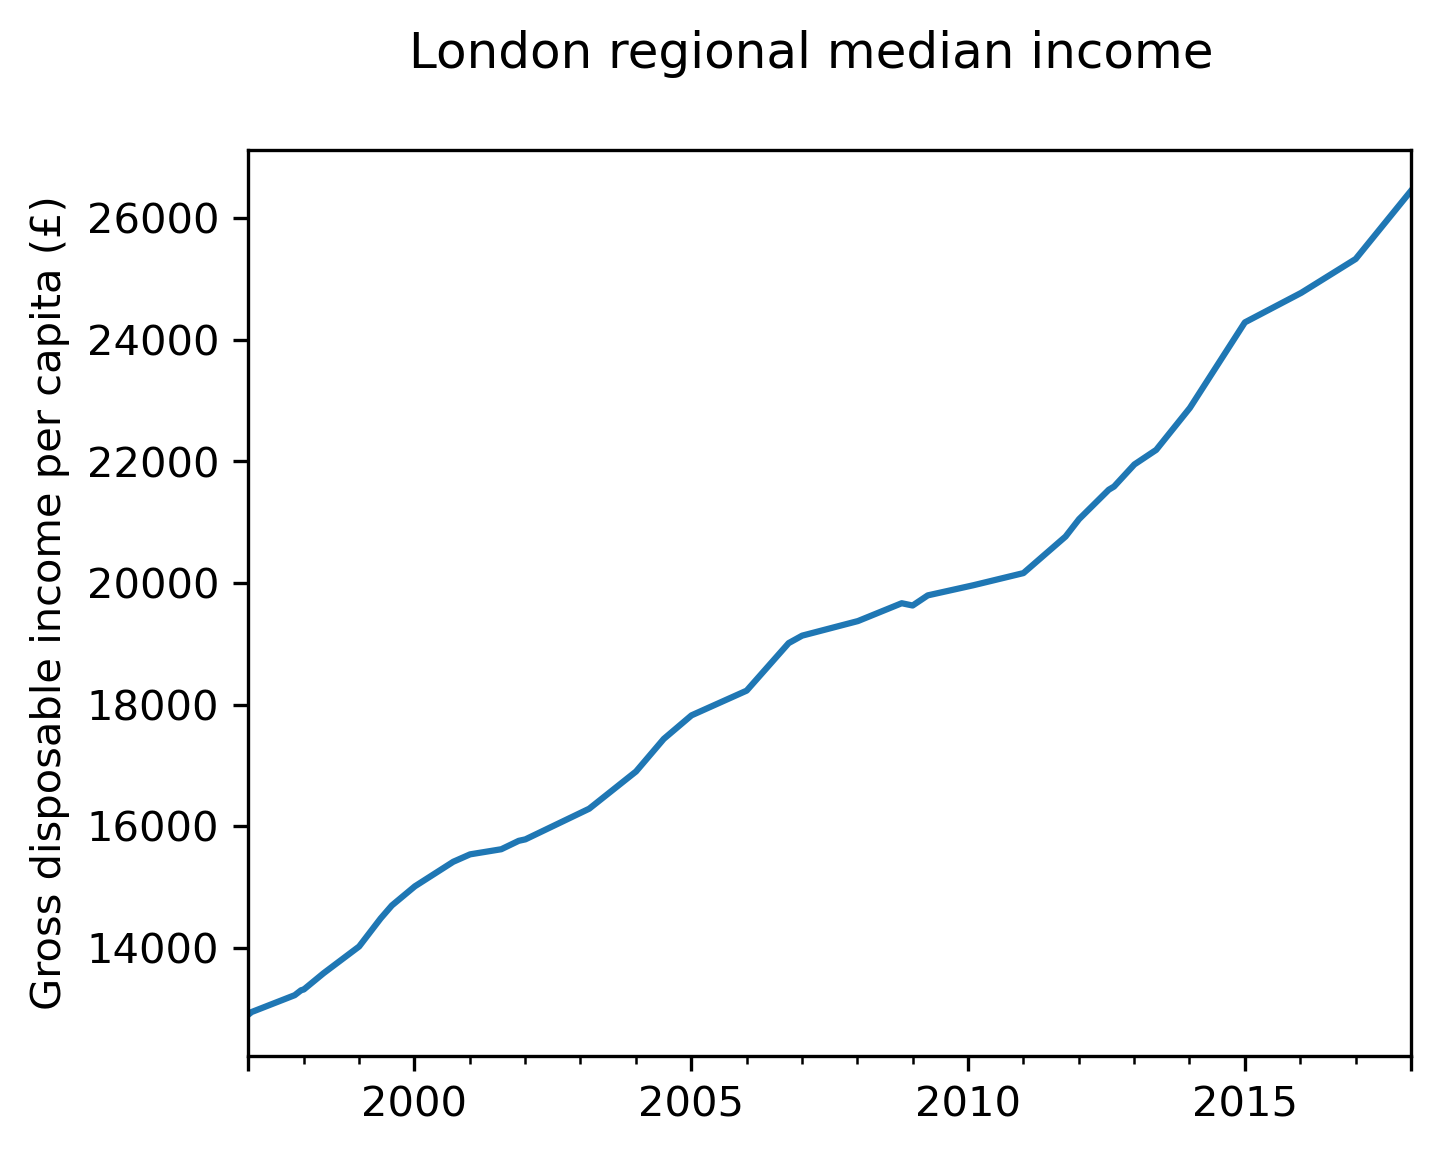

In [42]:
plt.figure(figsize=(5,4), dpi=300)
income_df["income"].plot()
plt.ylabel("Gross disposable income per capita (£)")
plt.suptitle("London regional median income")
plt.show()

#### Scatter plot mortality vs disposable income

In [25]:
income_df = income_df.join(mortality_df)

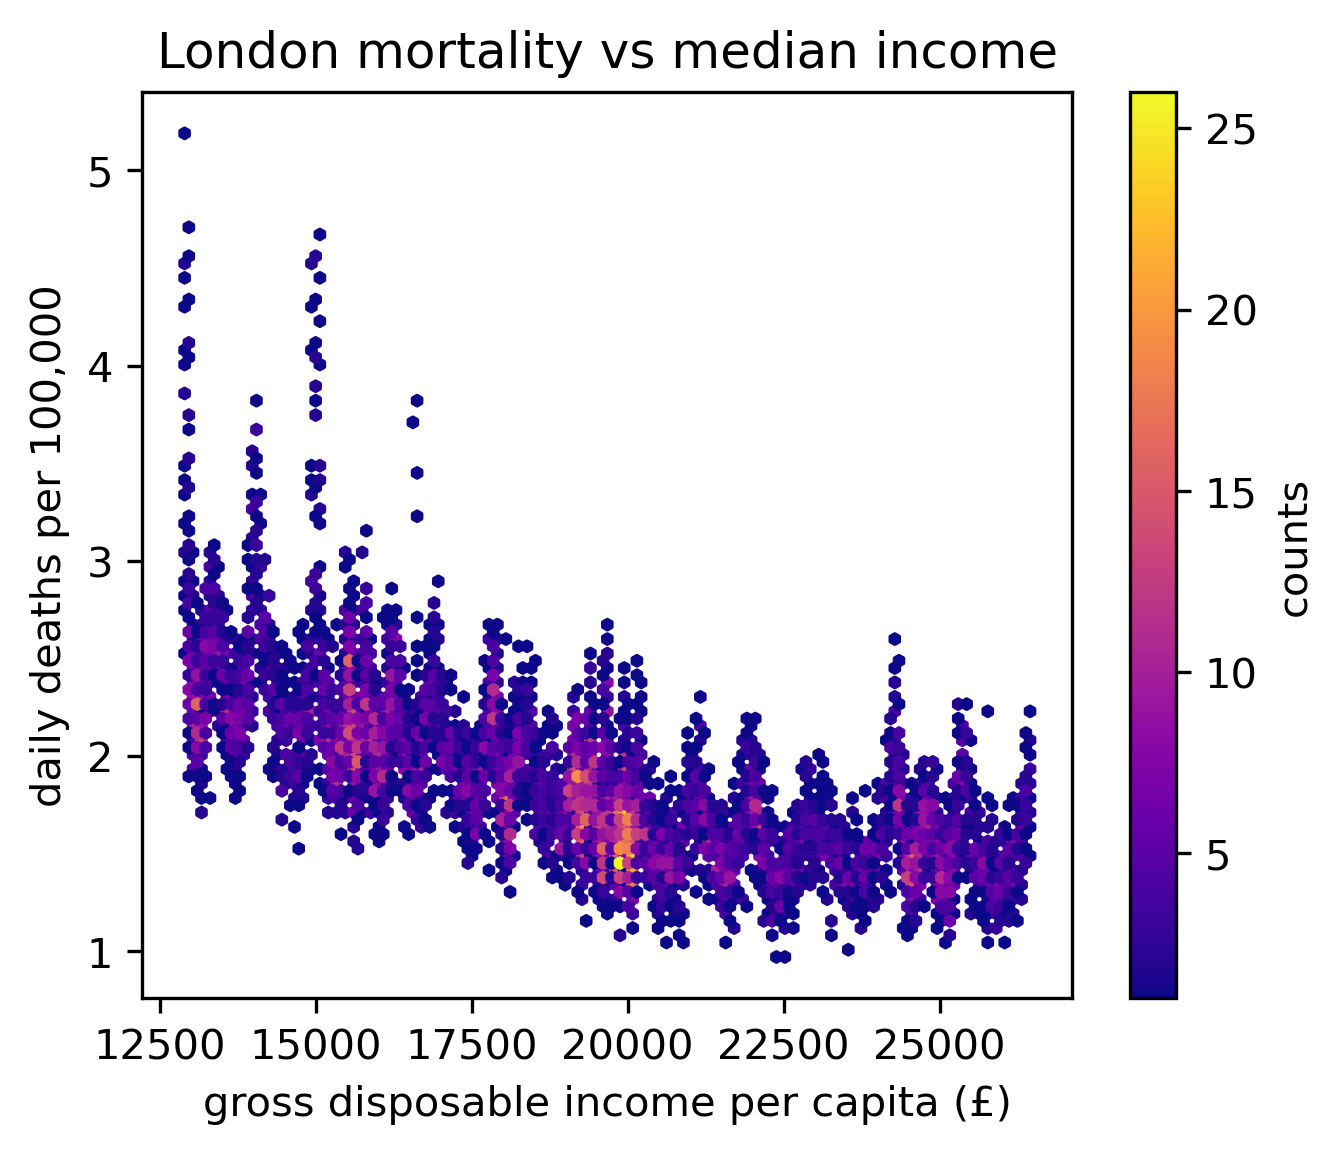

In [39]:
plot_correlation_hexbin(income_df.income, income_df.deaths_per_100k, 
                        gridsize=100, 
                        xlabel="gross disposable income per capita (£)", ylabel="daily deaths per 100,000",
                        title="London mortality vs median income")

## 3.2 | Time series decomposition: trends

**Trends** represent how the variable is changing overall through time.
**Seasonality** shows how the variable changes within a given period e.g. year, month.
**Residual** activity is not explained by the trend or seasonality.

Additive model: 
`y(t) = Trend(t) + Seasonality(t) + Residual(t)`

Multiplicative model:
`y(t) = Trend(t) * Seasonality(t) * Residual(t)`

In [26]:
decomp_dict = {}

In [27]:
def plot_seasonal_decomposition(title, units, decomp_df, seasonal_year_plot=2010):
    
    plt.figure(figsize=(5,4), dpi=300)
    decomp_df["observed"].plot()
    decomp_df["trend"].plot()
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(title)
    plt.show()

    plt.figure(figsize=(5,4), dpi=300)
    decomp_df["trend"].plot(color="tab:orange")
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(f"{title}: trend")
    plt.show()

    plt.figure(figsize=(5,4), dpi=300)
    decomp_df.loc[decomp_df.index.year==seasonal_year_plot]["seasonal"].plot(color="tab:green")
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(f"{title}: seasonal variation")
    plt.show()

    plt.figure(figsize=(5,4), dpi=300)
    decomp_df["residual"].plot(color="tab:red")
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(f"{title}: residuals")
    plt.show()

#### Mortality data

Here we use the `seasonal_decompose()` function with an additive model. Note that we have to manually set `period` (for filtering) to `365`, because otherwise the function by default looks for weekly (`period=7`) trends when given daily data (inferred from the `DatetimeIndex`).

In [28]:
decomp = tsa.seasonal_decompose(mortality_df["deaths_per_100k"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_dict["mortality"] = decomp_df

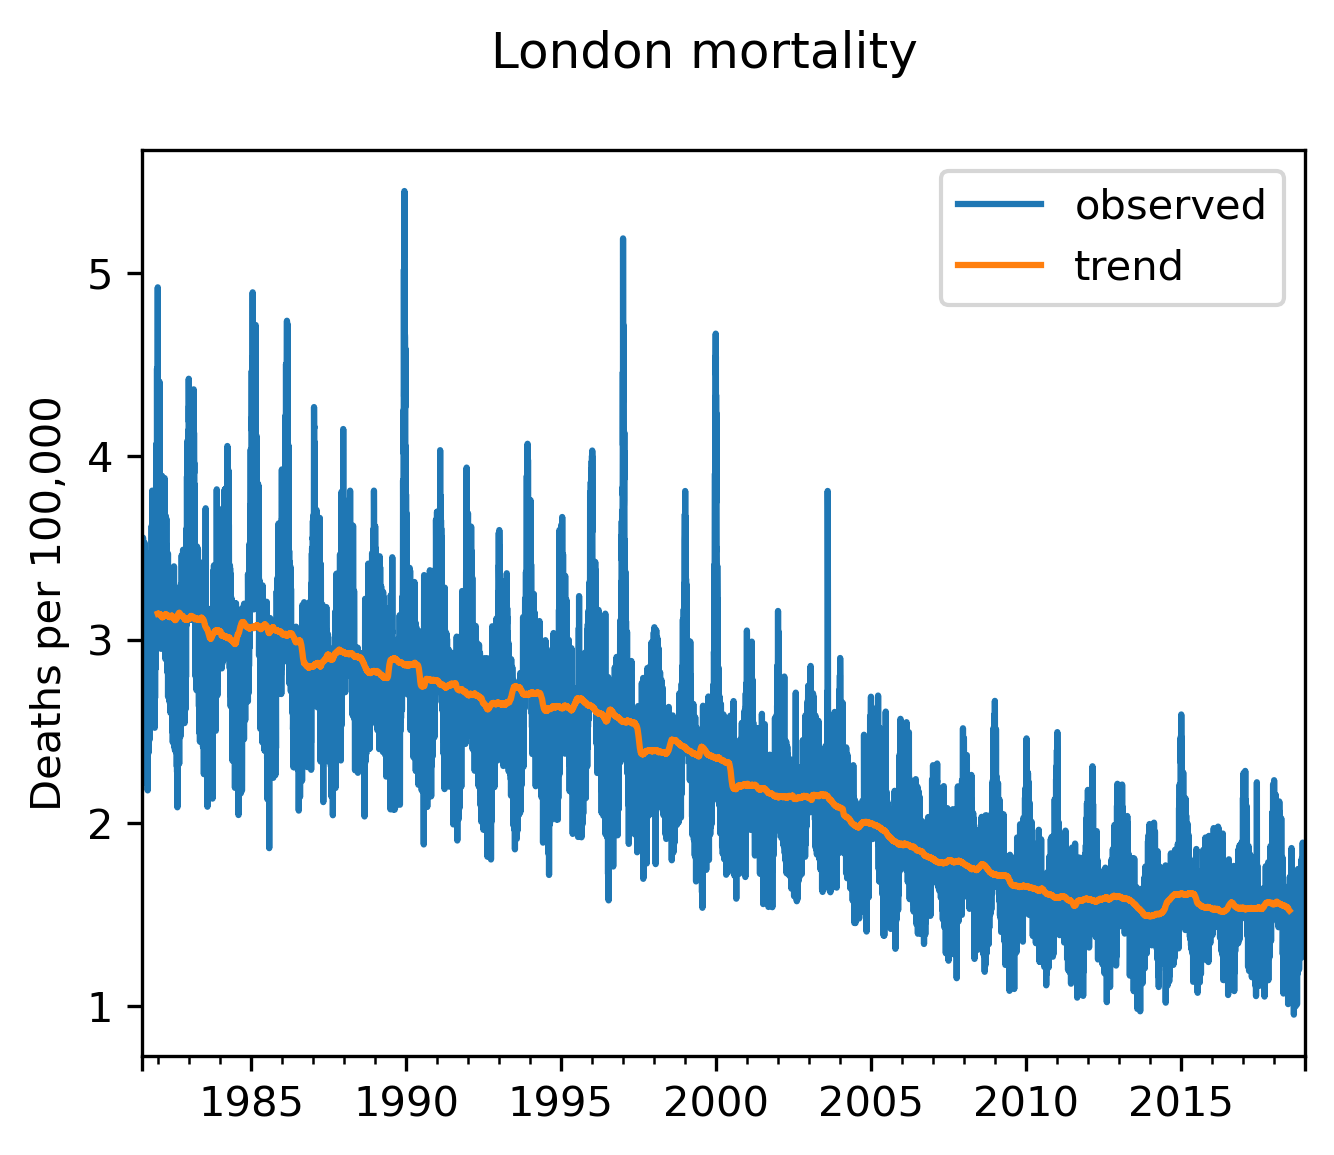

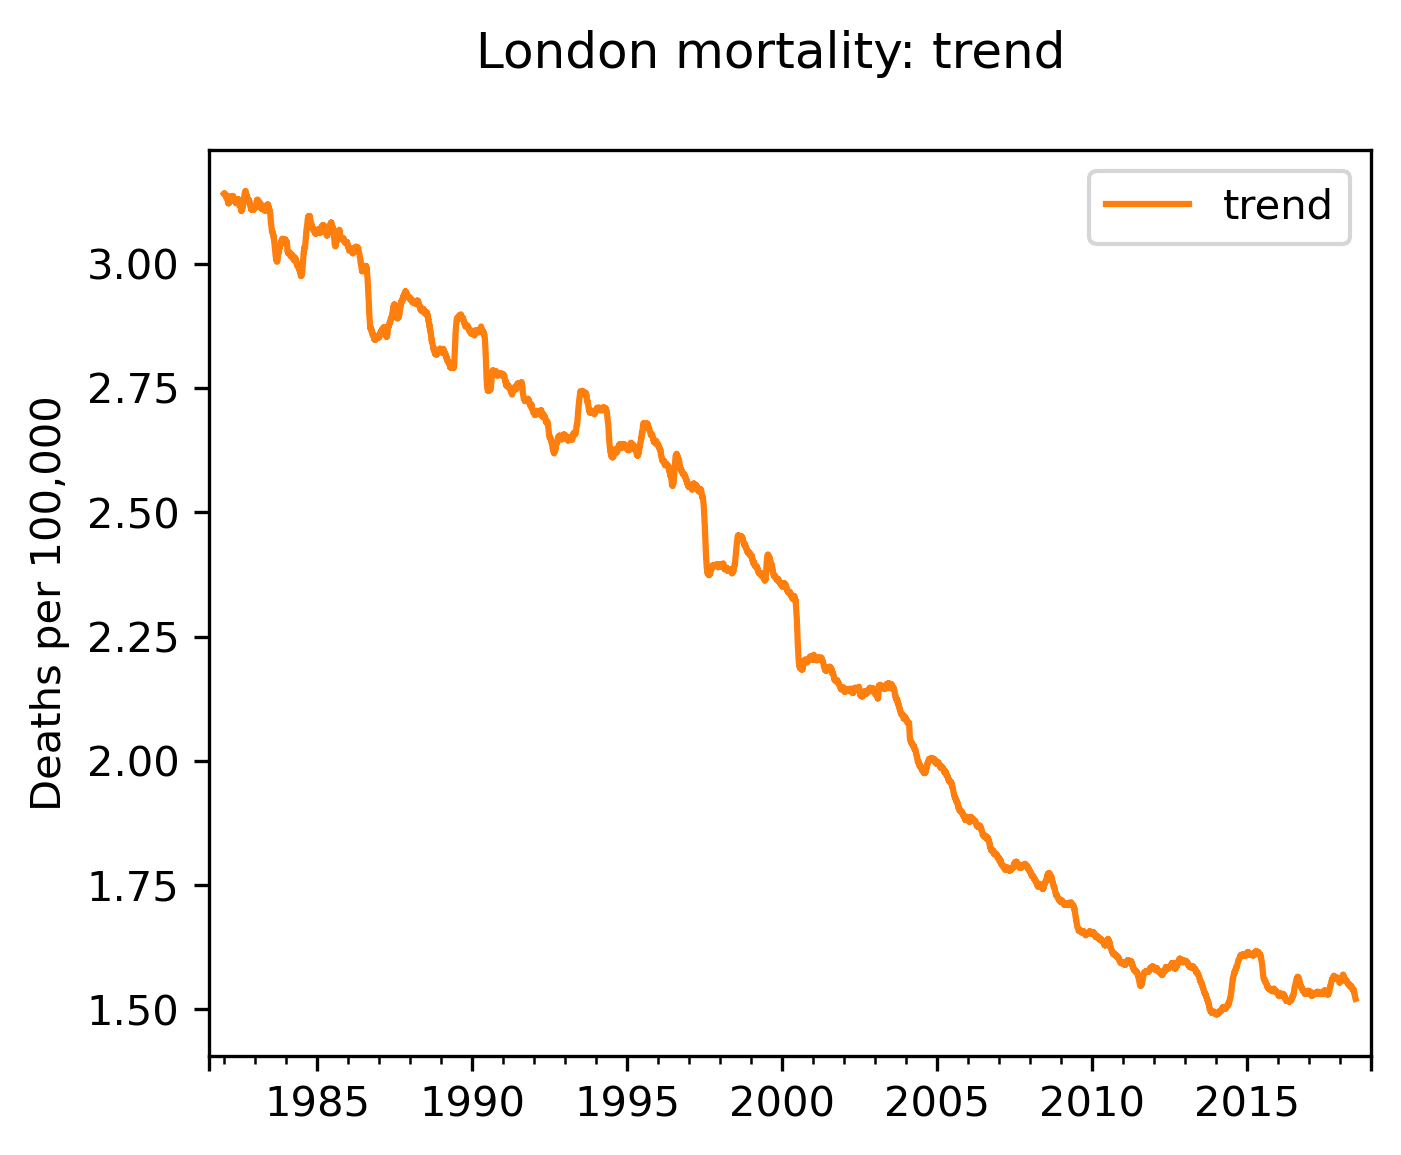

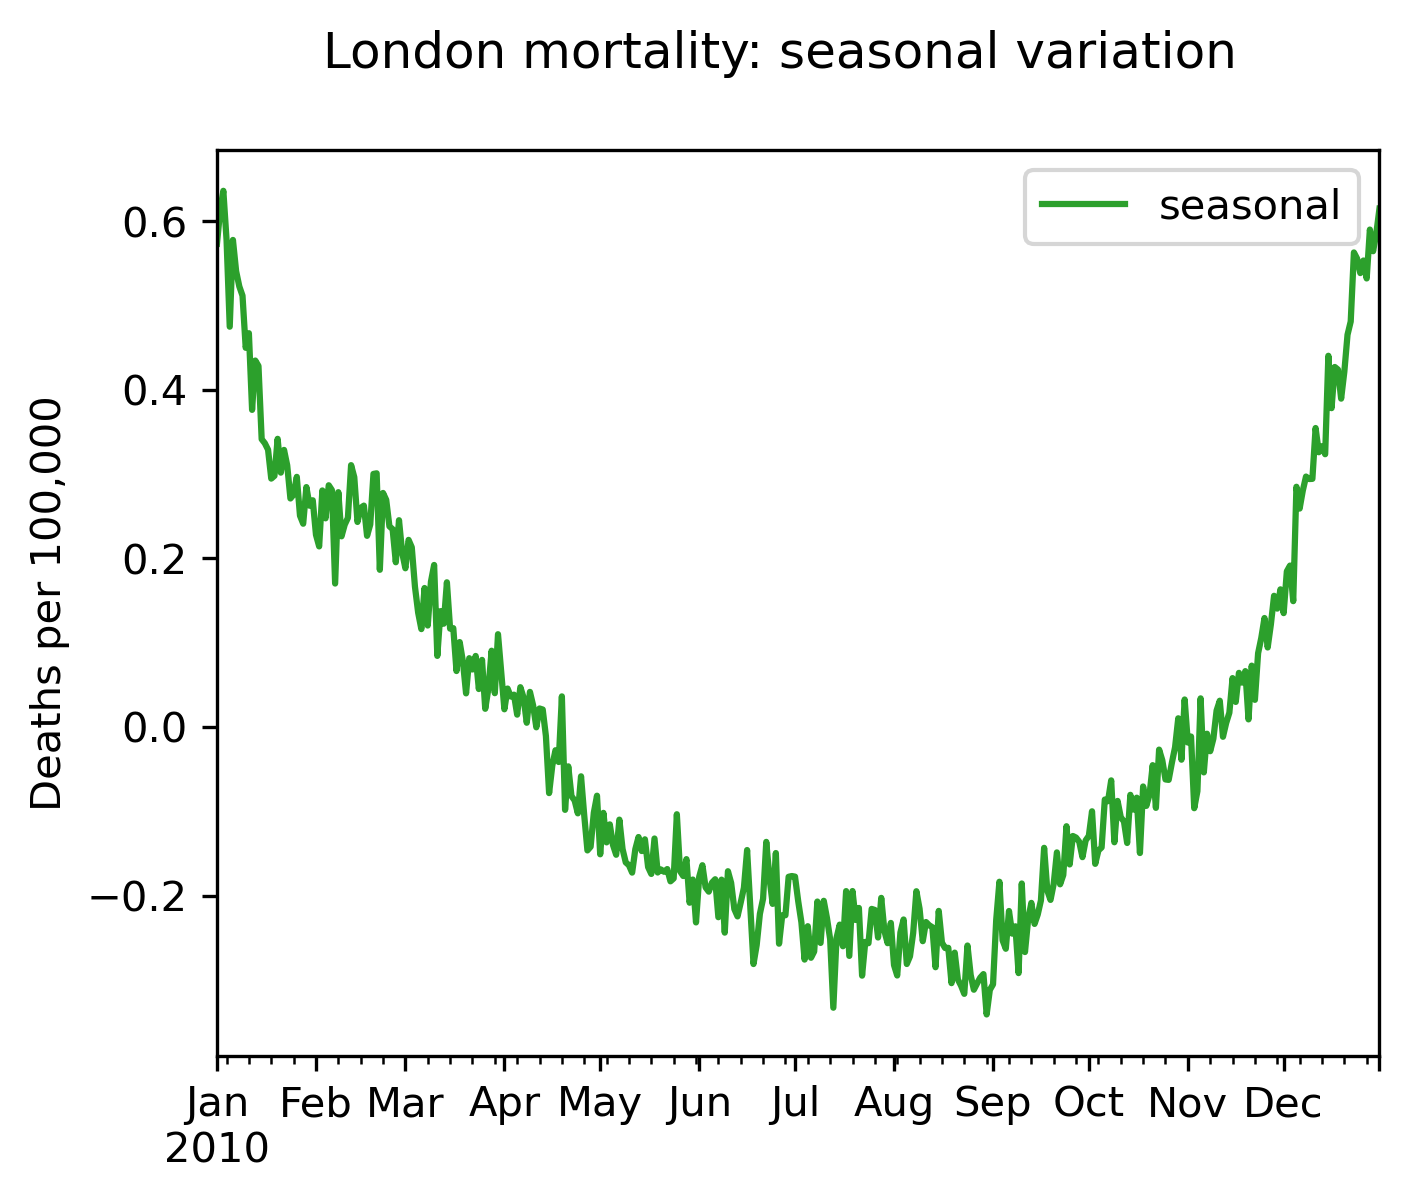

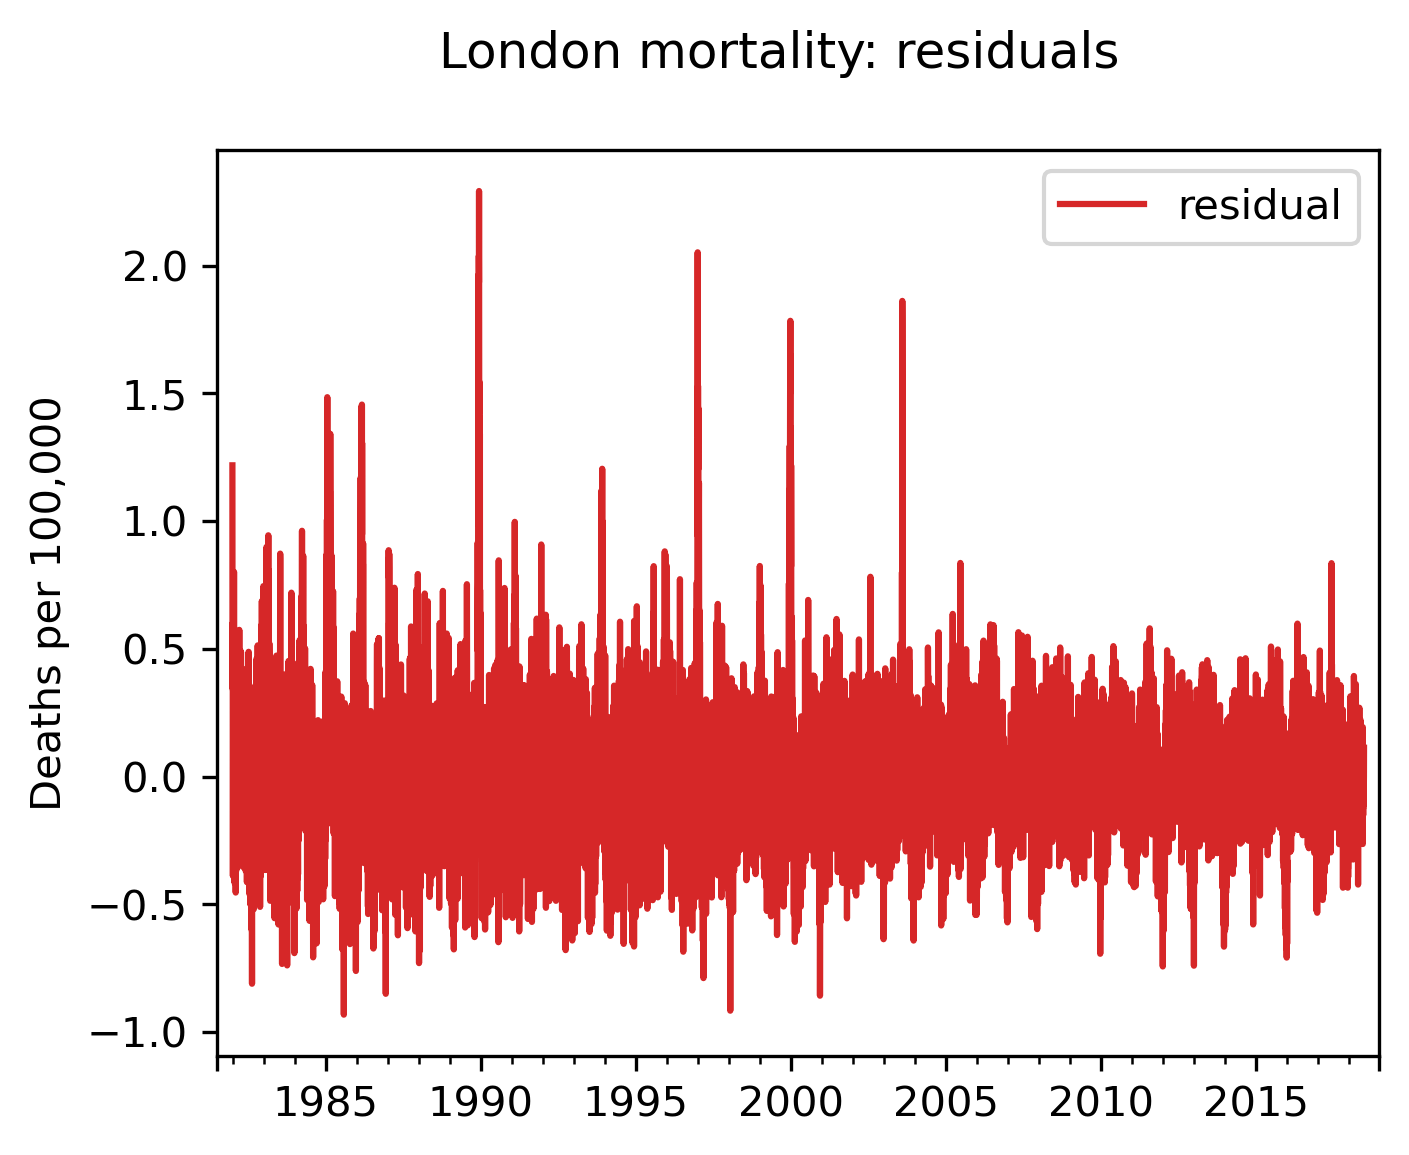

In [29]:
title = "London mortality"
units = "Deaths per 100,000"

plot_seasonal_decomposition(title, units, decomp_df, 2010)

#### NO$_2$ data

In [29]:
decomp = tsa.seasonal_decompose(daily_df["mean_NO2"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_dict["NO2"] = decomp_df

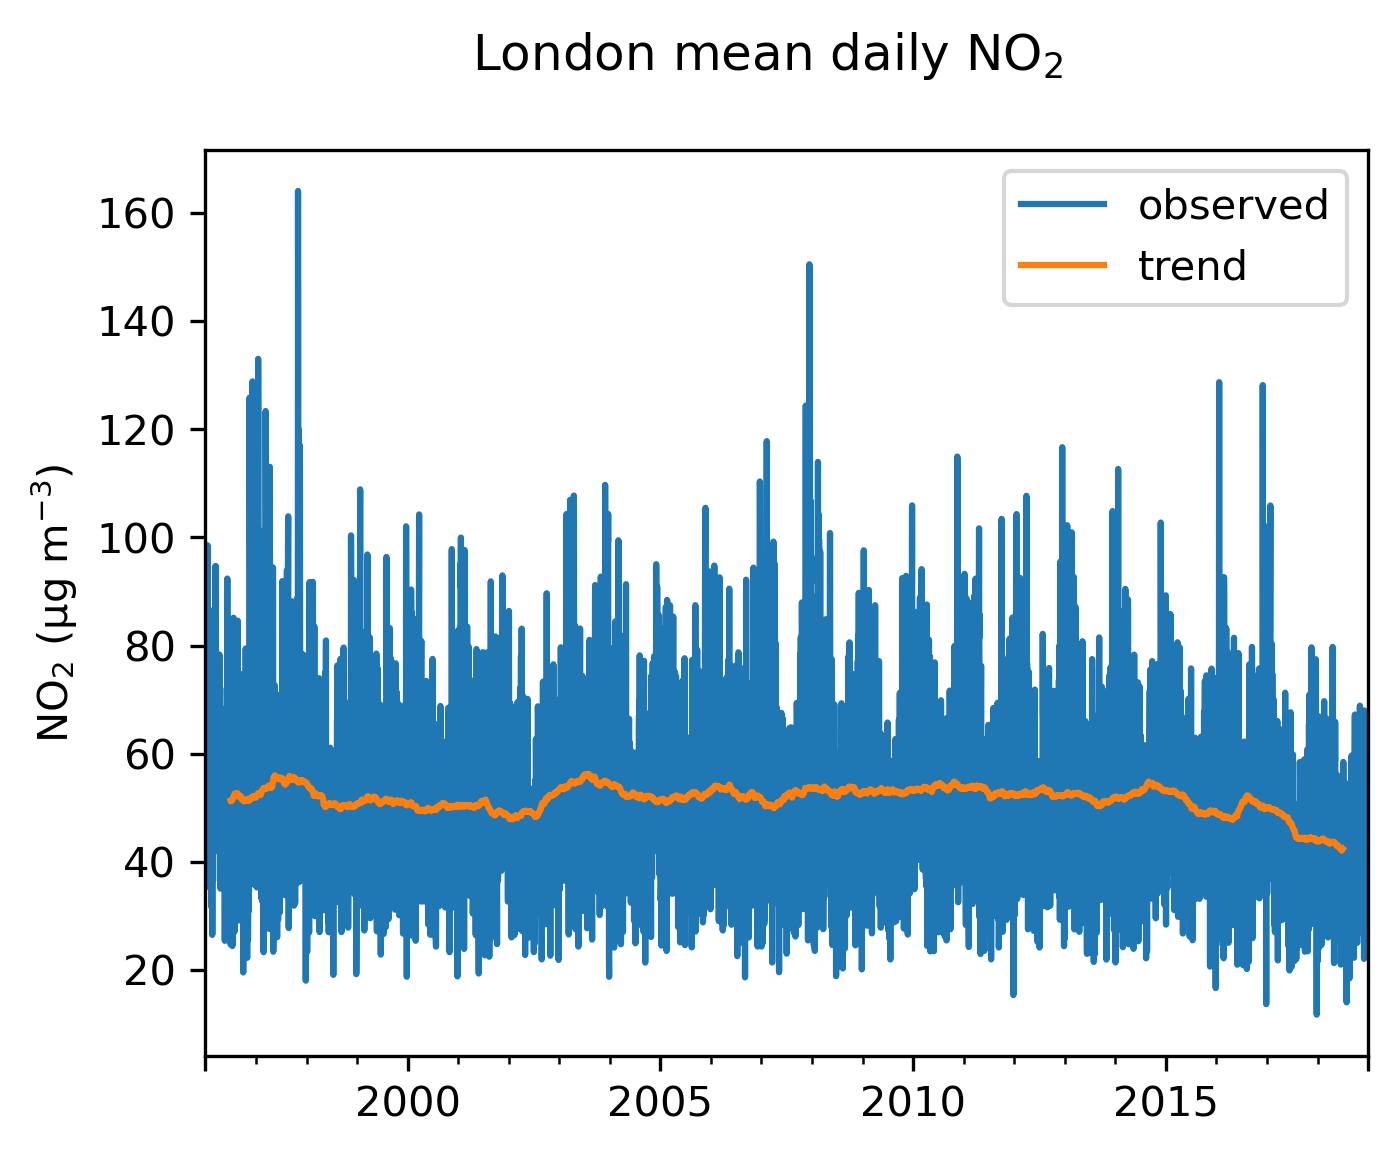

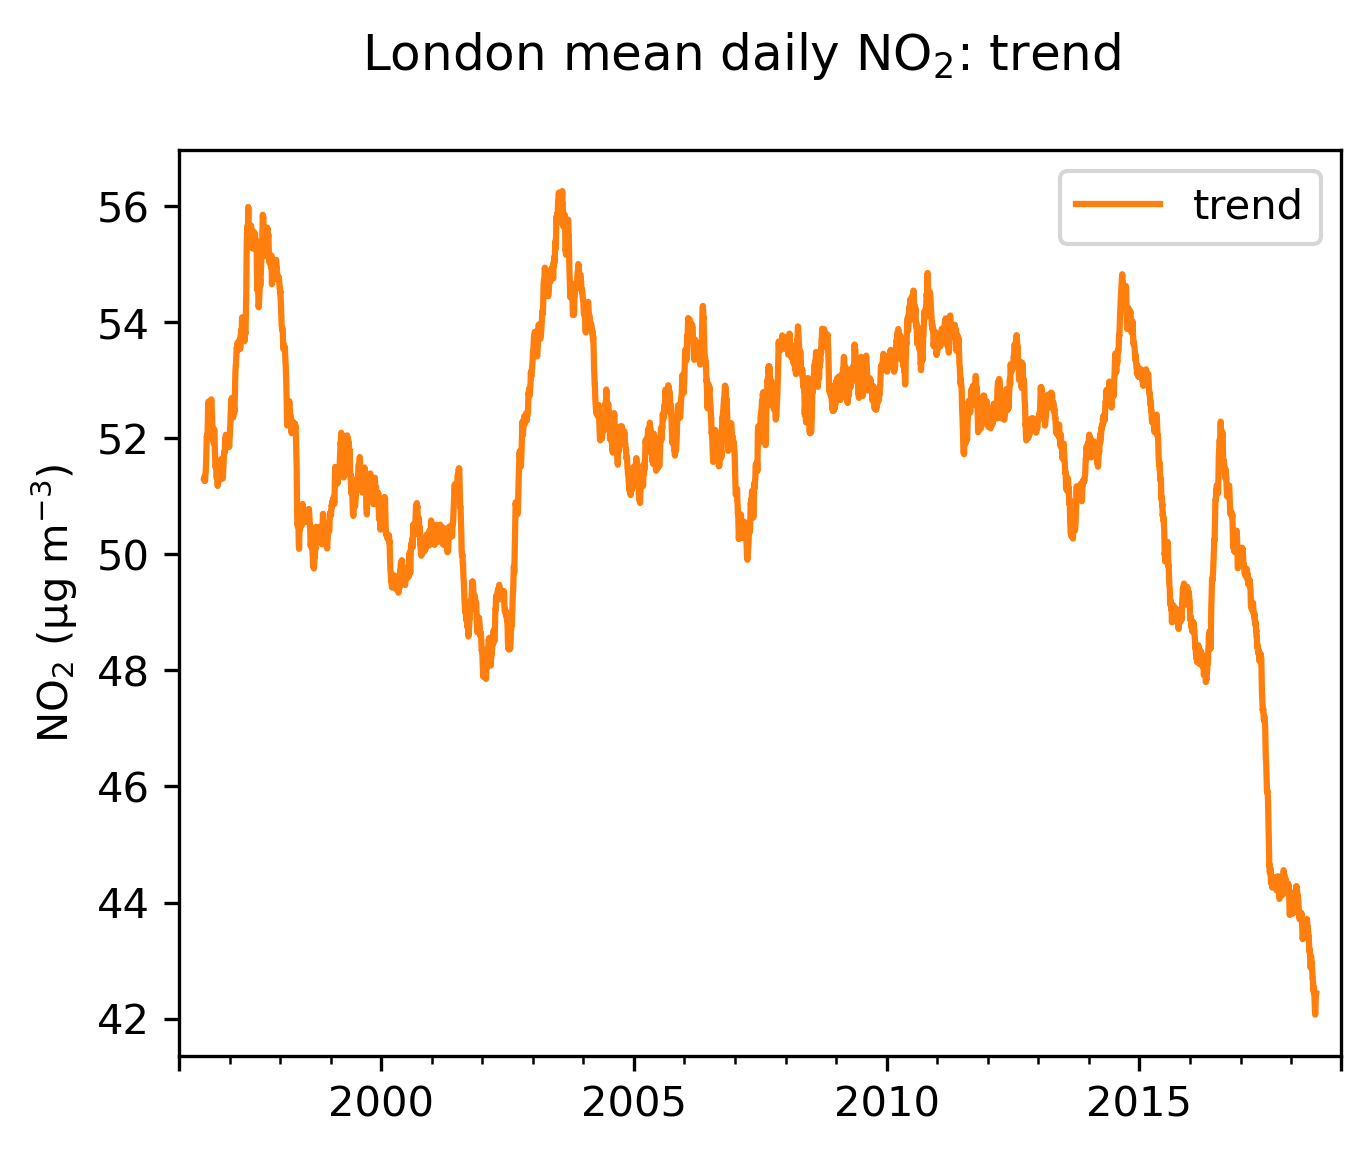

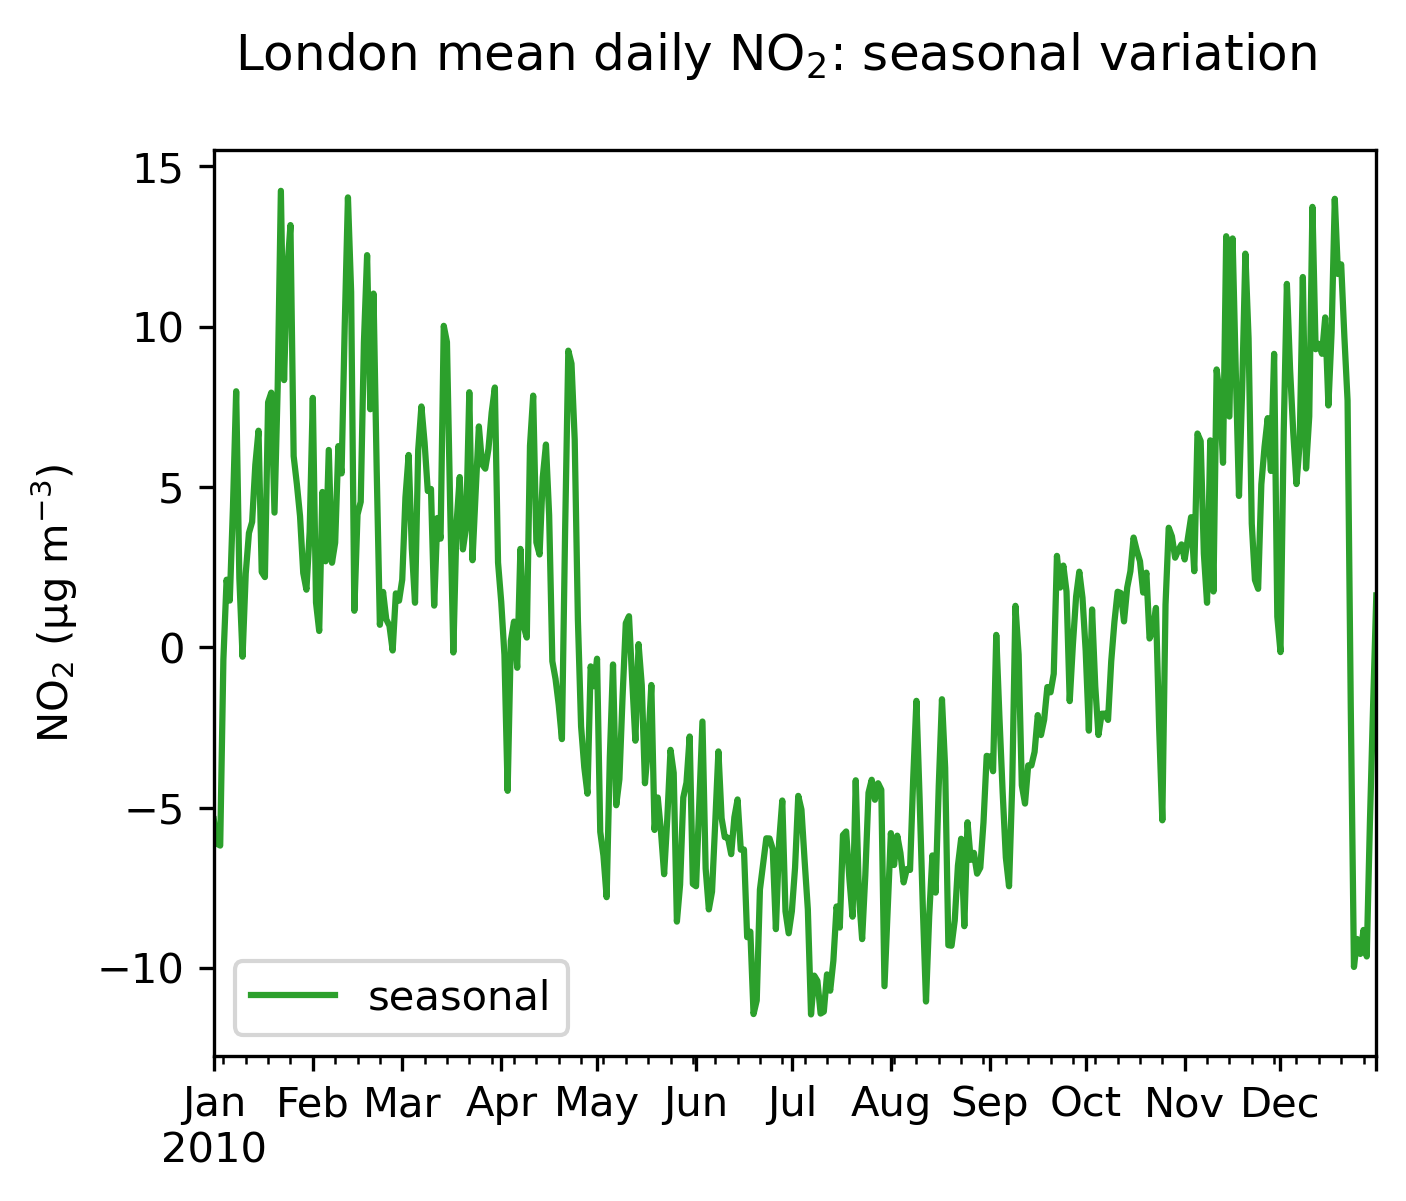

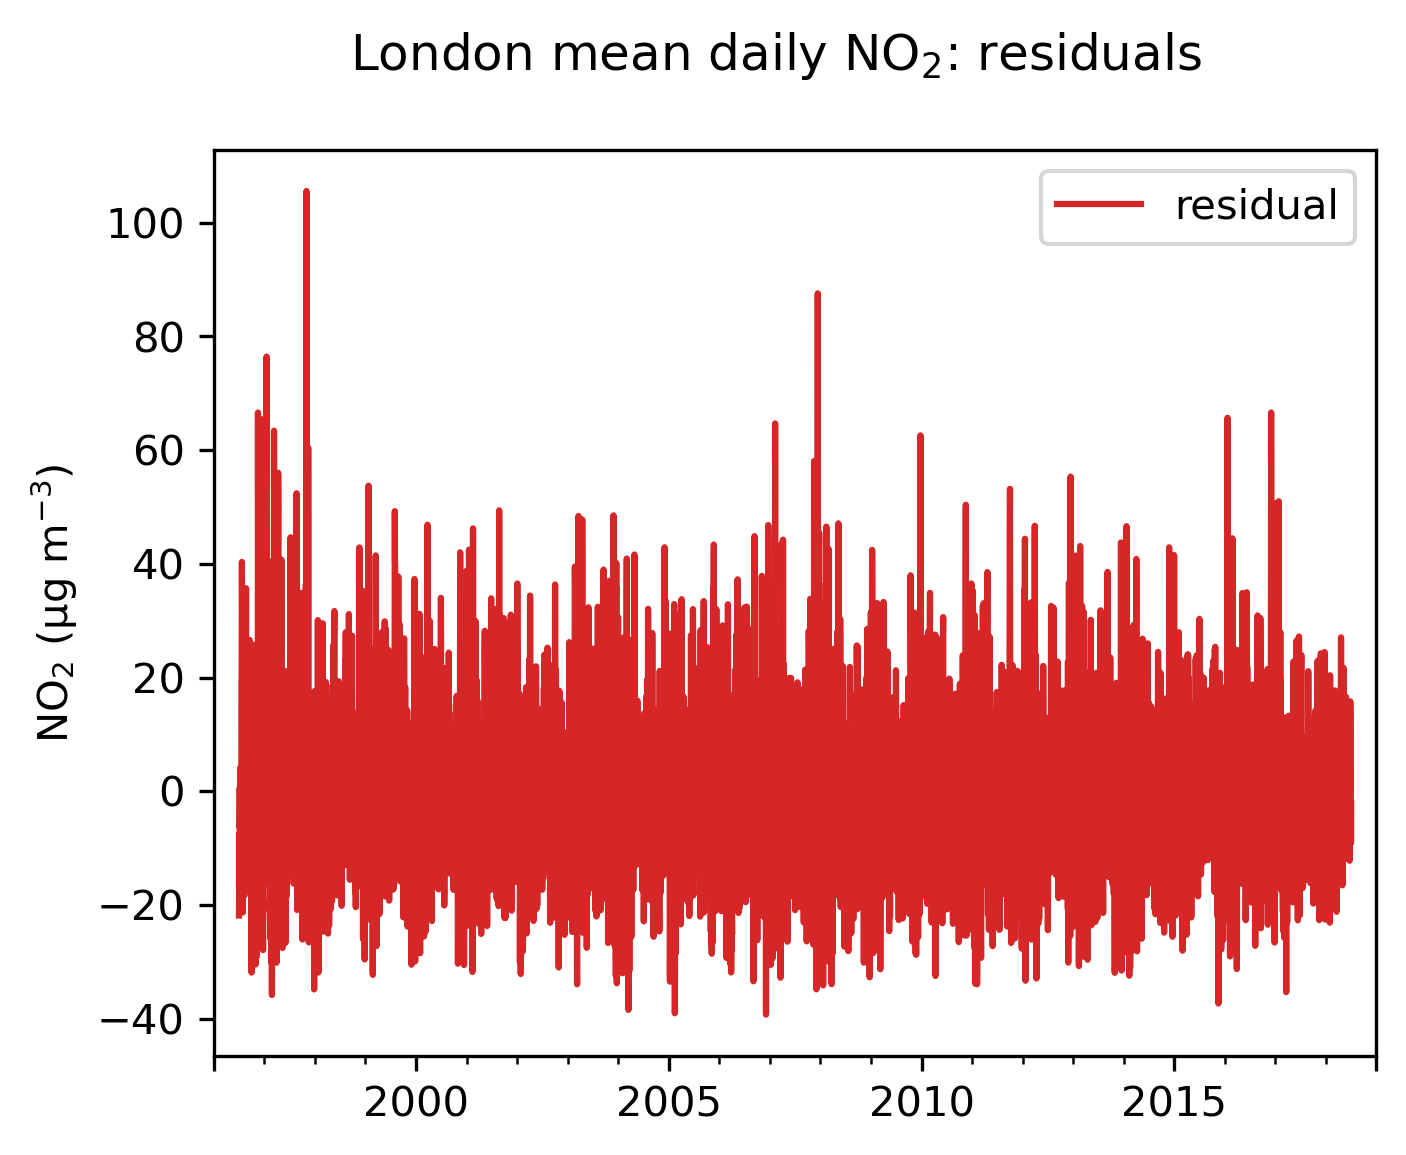

In [31]:
title = "London mean daily NO$_2$"
units = "NO$_2$ (µg m$^{-3}$)"

plot_seasonal_decomposition(title, units, decomp_df, 2010)

#### Temperature data

In [30]:
decomp = tsa.seasonal_decompose(daily_df.dropna()["temperature"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_dict["temperature"] = decomp_df

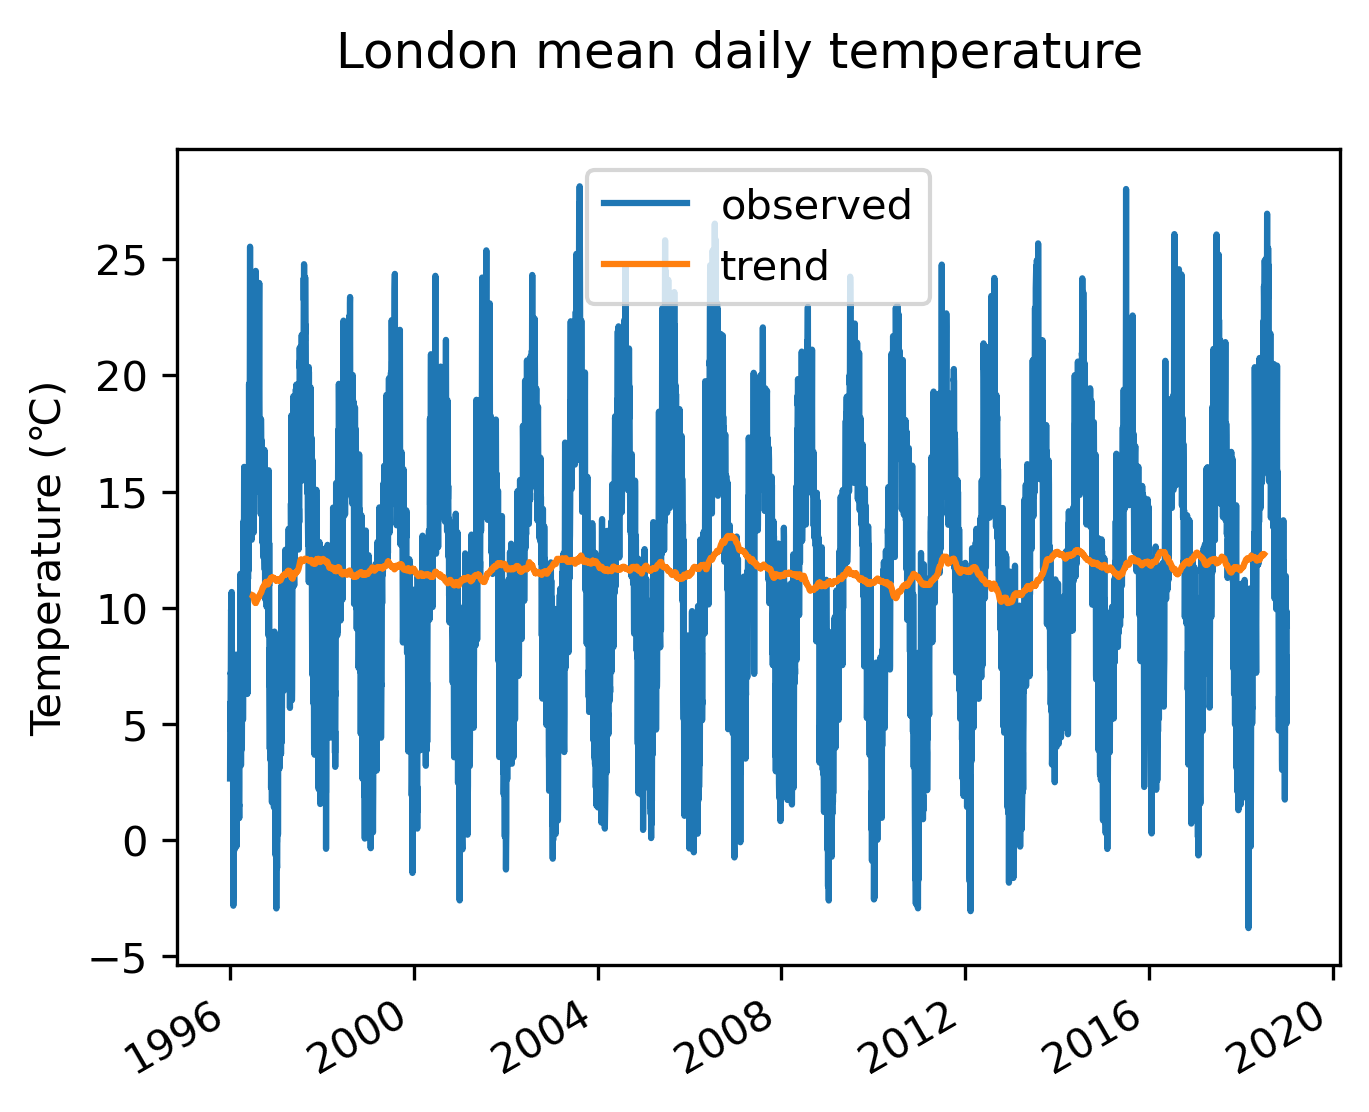

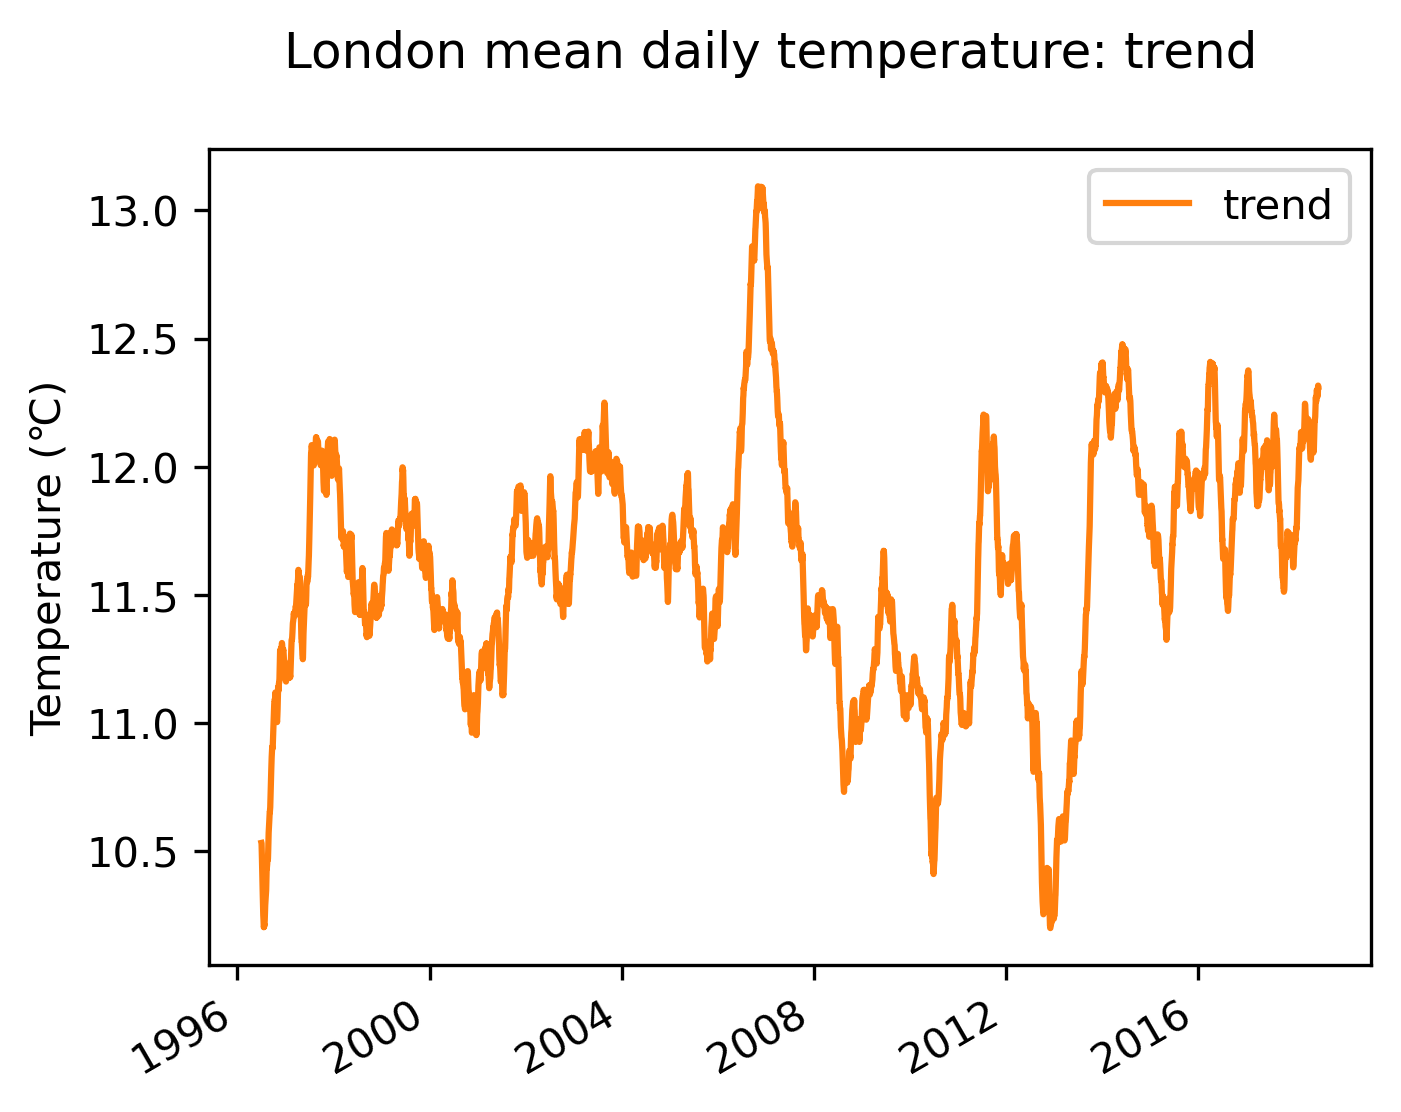

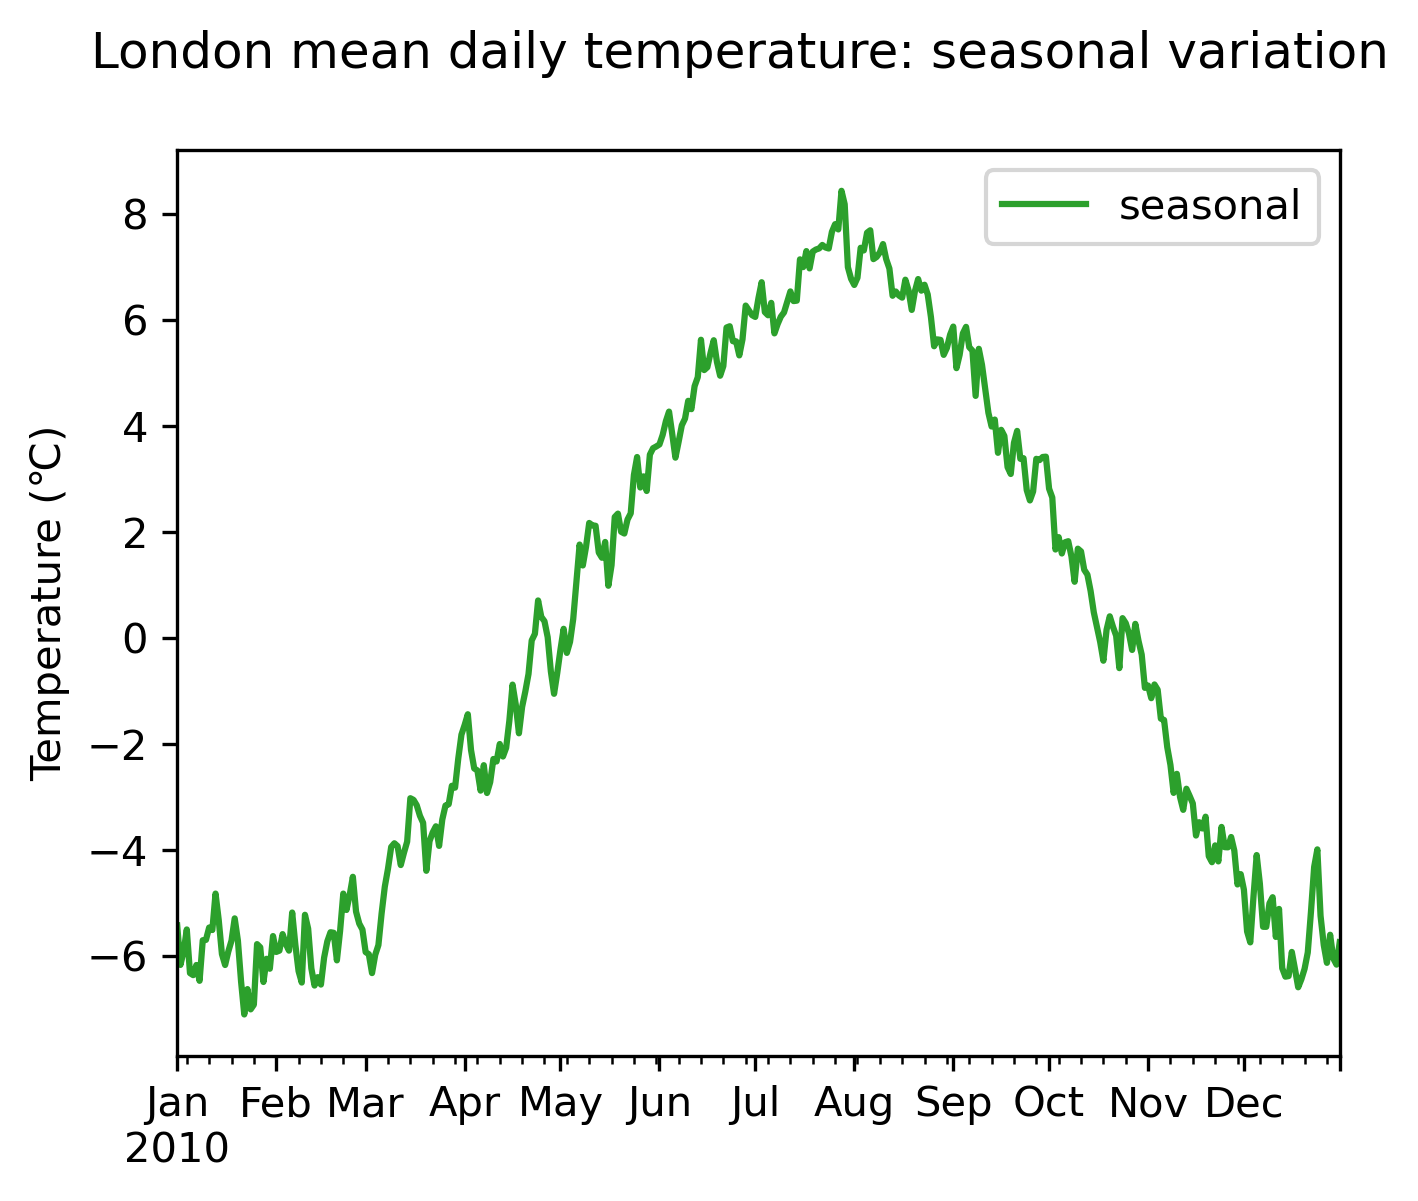

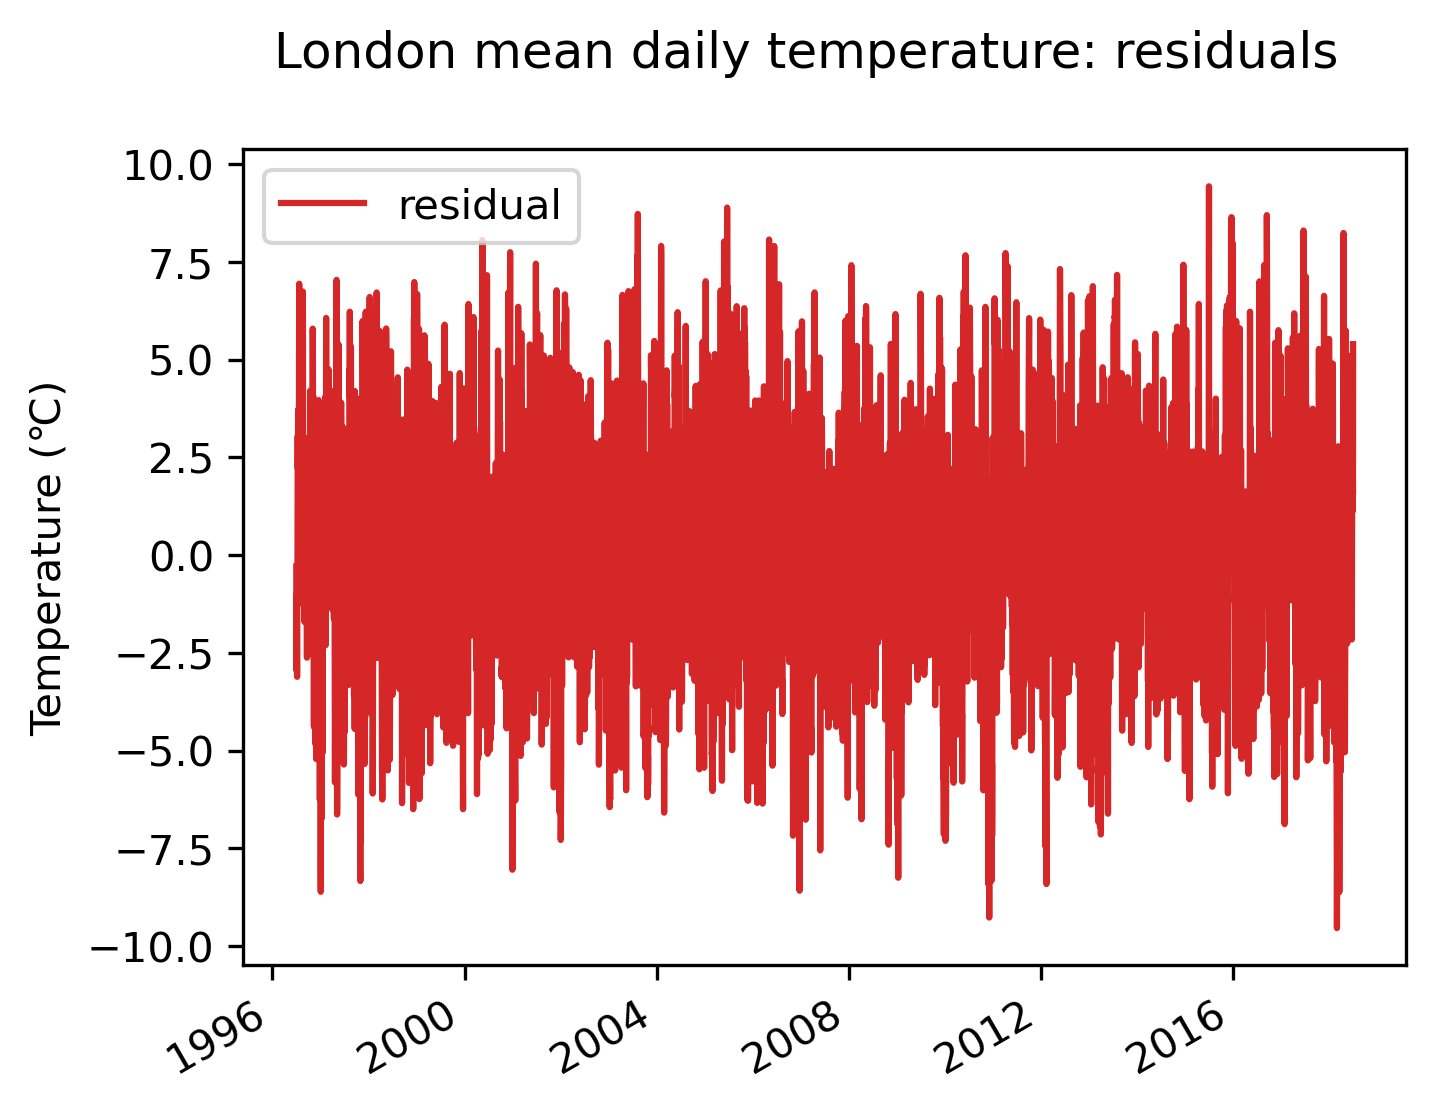

In [34]:
title = "London mean daily temperature"
units = "Temperature (℃)"

plot_seasonal_decomposition(title, units, decomp_df, 2010)

#### Disposable income vs mortality trend plots

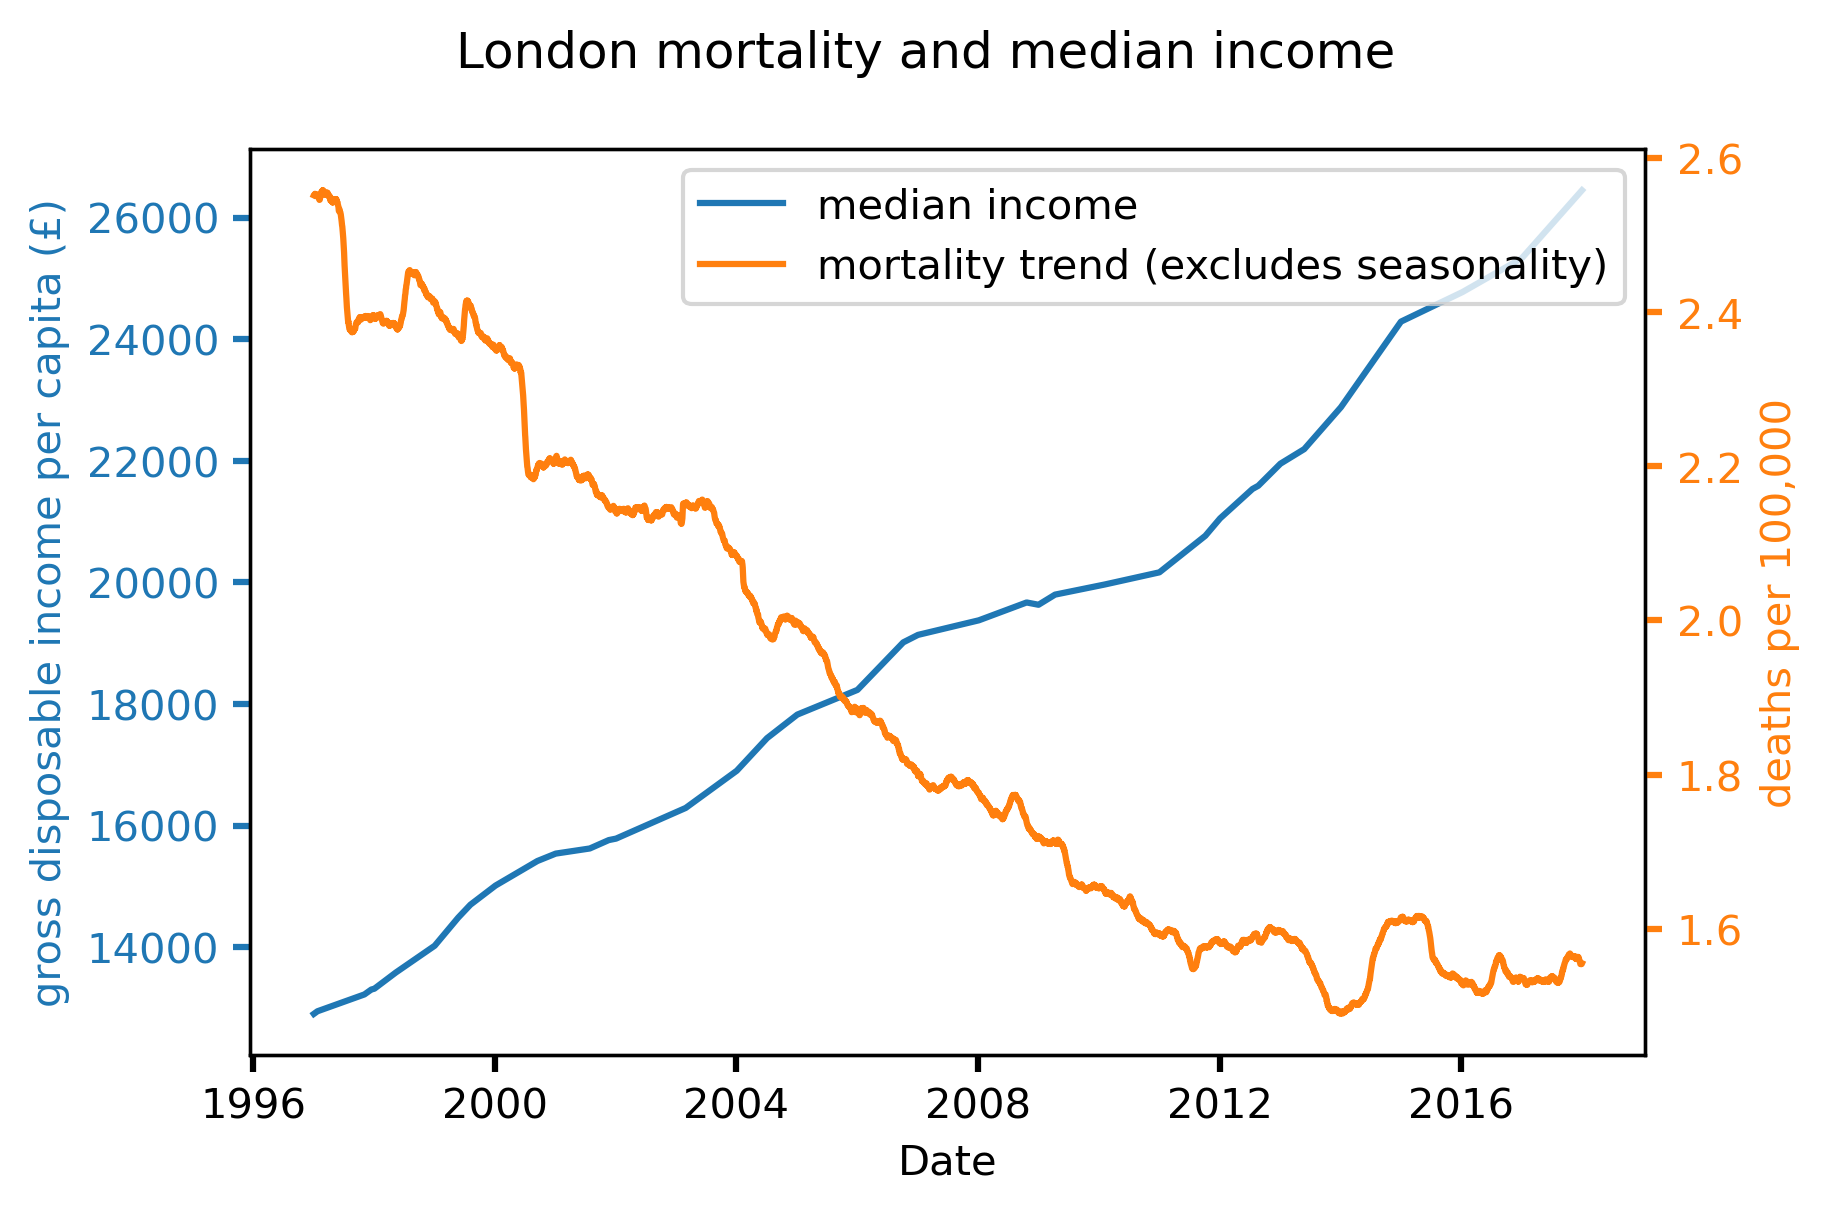

In [41]:
decomp_df = pd.DataFrame(income_df["income"]).join(pd.DataFrame({"mortality_trend":decomp_dict["mortality"].trend}))

fig, ax = plt.subplots(figsize=(6,4), dpi=300)
twin1 = ax.twinx()

p1, = ax.plot(decomp_df.index, decomp_df["income"],"tab:blue", label="median income")
p2, = twin1.plot(decomp_df.index, decomp_df["mortality_trend"], "tab:orange", label="mortality trend (excludes seasonality)")

ax.set_xlabel("Date")
ax.set_ylabel("gross disposable income per capita (£)")
twin1.set_ylabel("deaths per 100,000")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

plt.legend(handles=[p1, p2])
plt.suptitle("London mortality and median income")

plt.show()

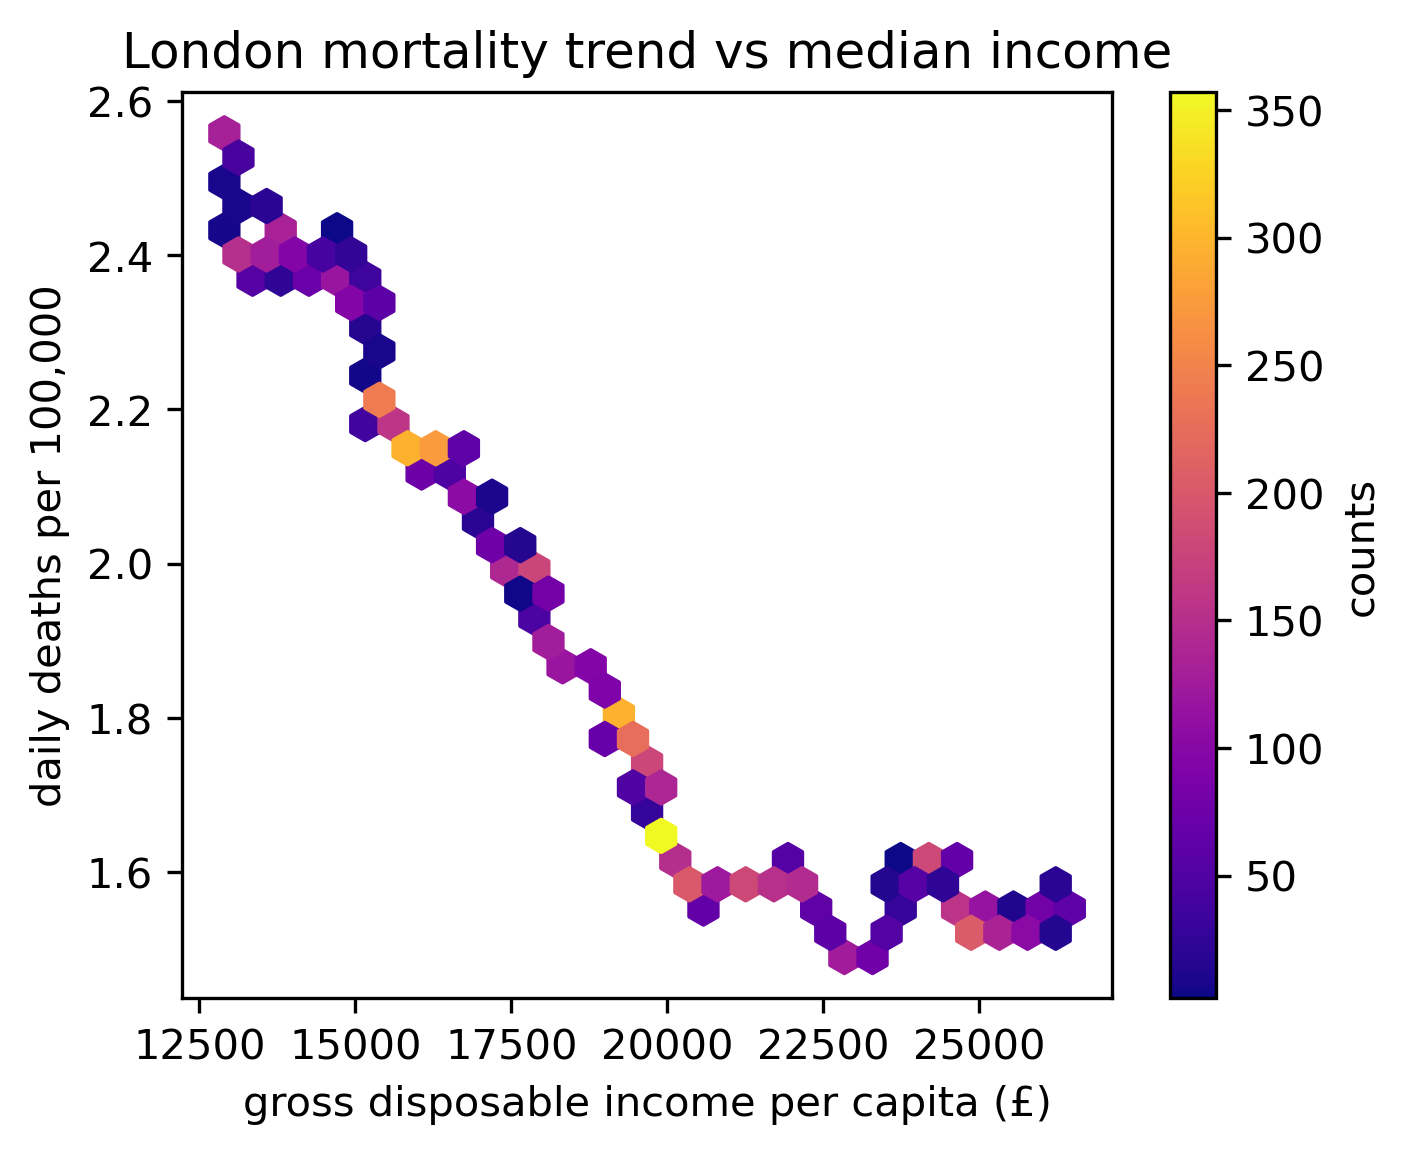

In [42]:
plot_correlation_hexbin(decomp_df.income, decomp_df.mortality_trend, 
                        gridsize=30, 
                        xlabel="gross disposable income per capita (£)", ylabel="daily deaths per 100,000",
                        title="London mortality trend vs median income")

### Mortality de-trended vs temperature

Are the mortality vs temperature correlation clusters due to the mortality trend through time?
- Plot mortality seasonal+residual against temperature.

In [43]:
data_df = pd.DataFrame(decomp_dict["mortality"].seasonal + decomp_dict["mortality"].residual).join(pd.DataFrame(decomp_dict["temperature"].observed)).dropna()
data_df.columns = ["mortality_detrended","temperature_observed"]

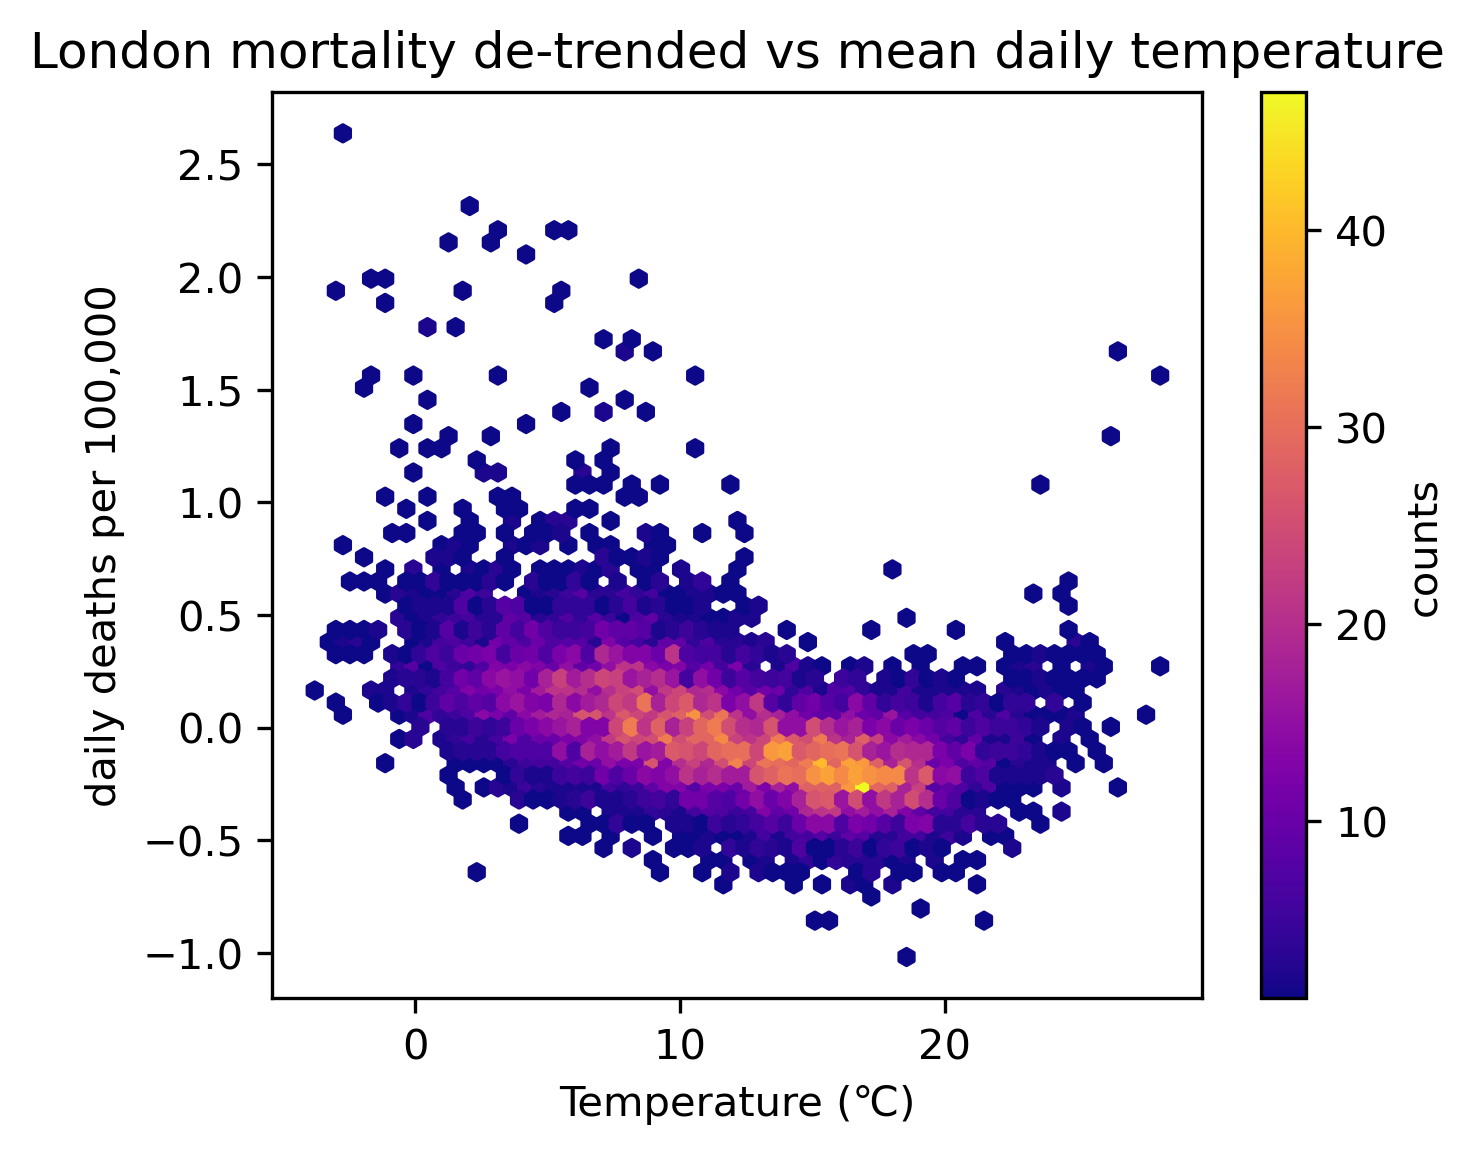

In [44]:
plot_correlation_hexbin(data_df.temperature_observed, data_df.mortality_detrended, 
                        gridsize=60, 
                        xlabel="Temperature (℃)", ylabel="daily deaths per 100,000",
                        title="London mortality de-trended vs mean daily temperature")

### Mortality de-seasonalised vs GDHI
Mortality trend+residuals against GDHI

In [45]:
data_df = pd.DataFrame(decomp_dict["mortality"].trend + decomp_dict["mortality"].residual).join(income_df["income"]).dropna()
data_df.columns = ["mortality_deseasonalised","GDHI_observed"]

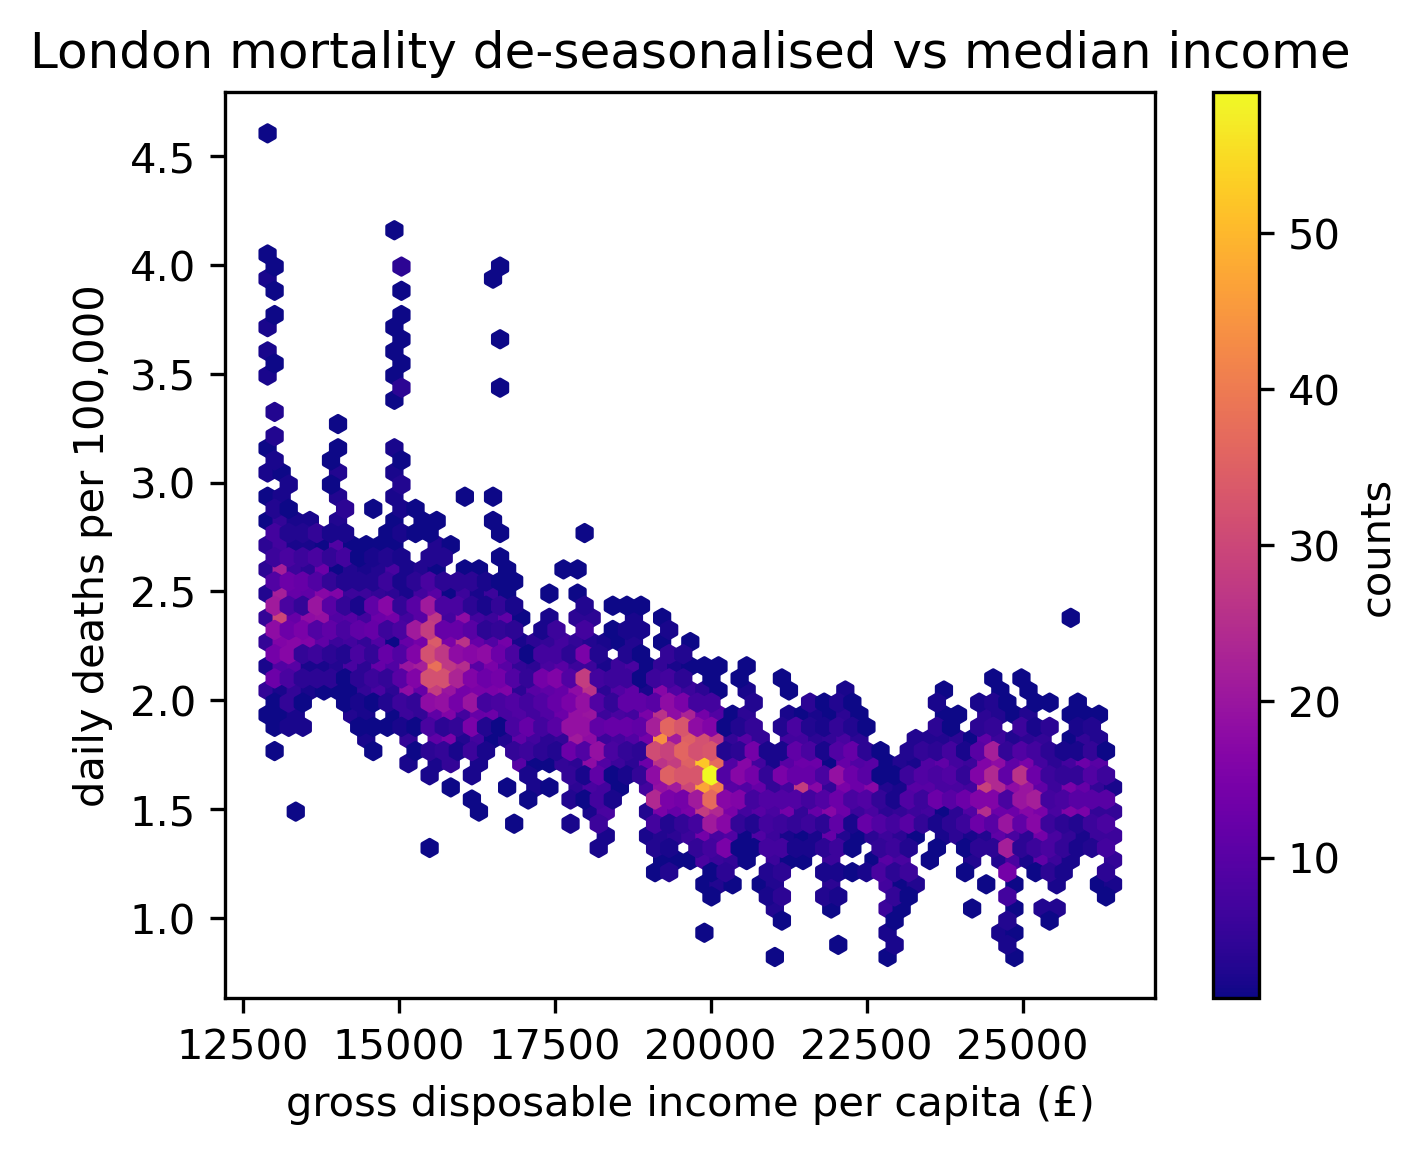

In [46]:
plot_correlation_hexbin(data_df.GDHI_observed, data_df.mortality_deseasonalised, 
                        gridsize=60, 
                        xlabel="gross disposable income per capita (£)", ylabel="daily deaths per 100,000",
                        title="London mortality de-seasonalised vs median income")

### Mortality de-seasonalised vs NO2 de-seasonalised
The seasonality in each or mortality and NO2 is believed to be driven by seasonal temperature changes, so this correlation plot attempts to visualise whether there's an association between NO2 and mortality independently of the effects of temperature on both.

- In hindsight I'm not 100% sure this makes sense.

In [47]:
data_df = pd.DataFrame(decomp_dict["mortality"].trend + decomp_dict["mortality"].residual, columns=["mortality_deseasonalised"]).join(pd.DataFrame(decomp_dict["NO2"].trend + decomp_dict["NO2"].residual, columns=["NO2_deseasonalised"])).dropna()

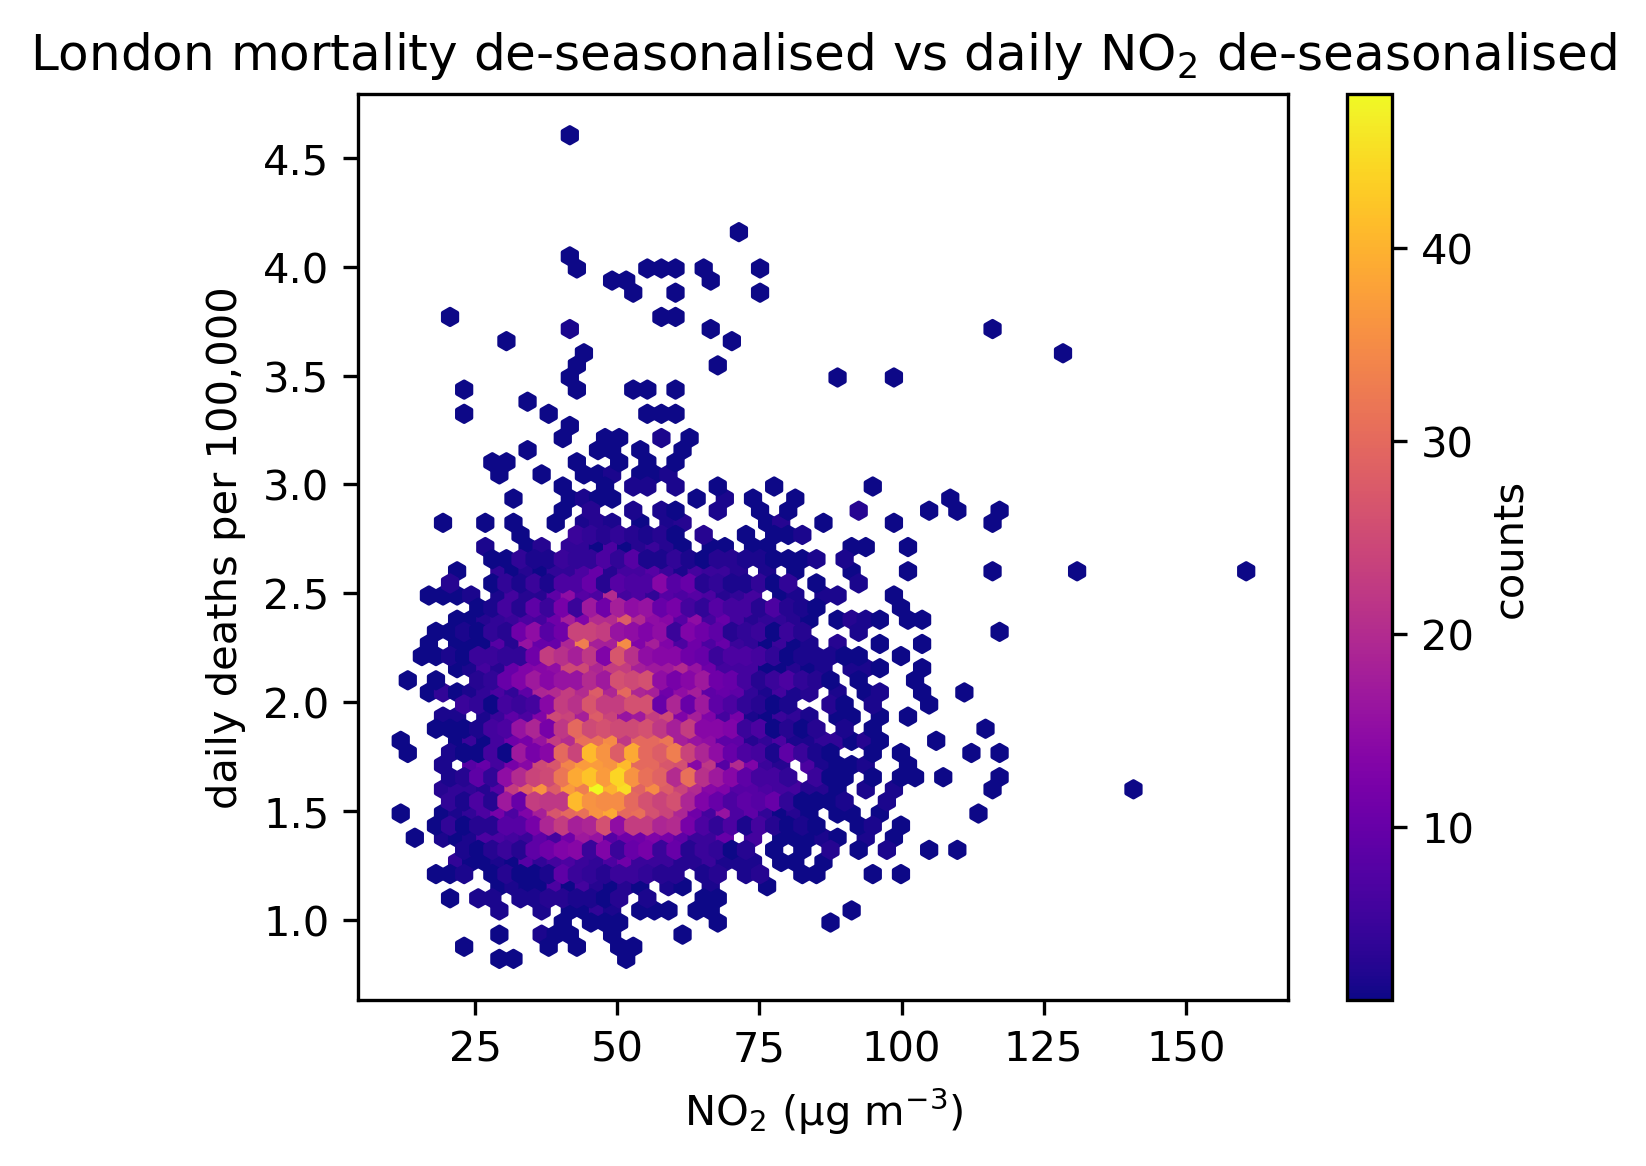

In [48]:
plot_correlation_hexbin(data_df.NO2_deseasonalised, data_df.mortality_deseasonalised, 
                        gridsize=60, 
                        xlabel="NO$_2$ (µg m$^{-3}$)", ylabel="daily deaths per 100,000",
                        title="London mortality de-seasonalised vs daily NO$_2$ de-seasonalised")

### Mortality residuals vs NO2 (observed)
If we infer that GDHI predict the mortality trend and temperature predicts the mortality seasonality, now we test if NO2 predicts the mortality residuals.

In [49]:
data_df = pd.DataFrame(decomp_dict["mortality"].residual).join(decomp_dict["NO2"].observed).dropna()
data_df.columns = ["mortality_residual","NO2_observed"]

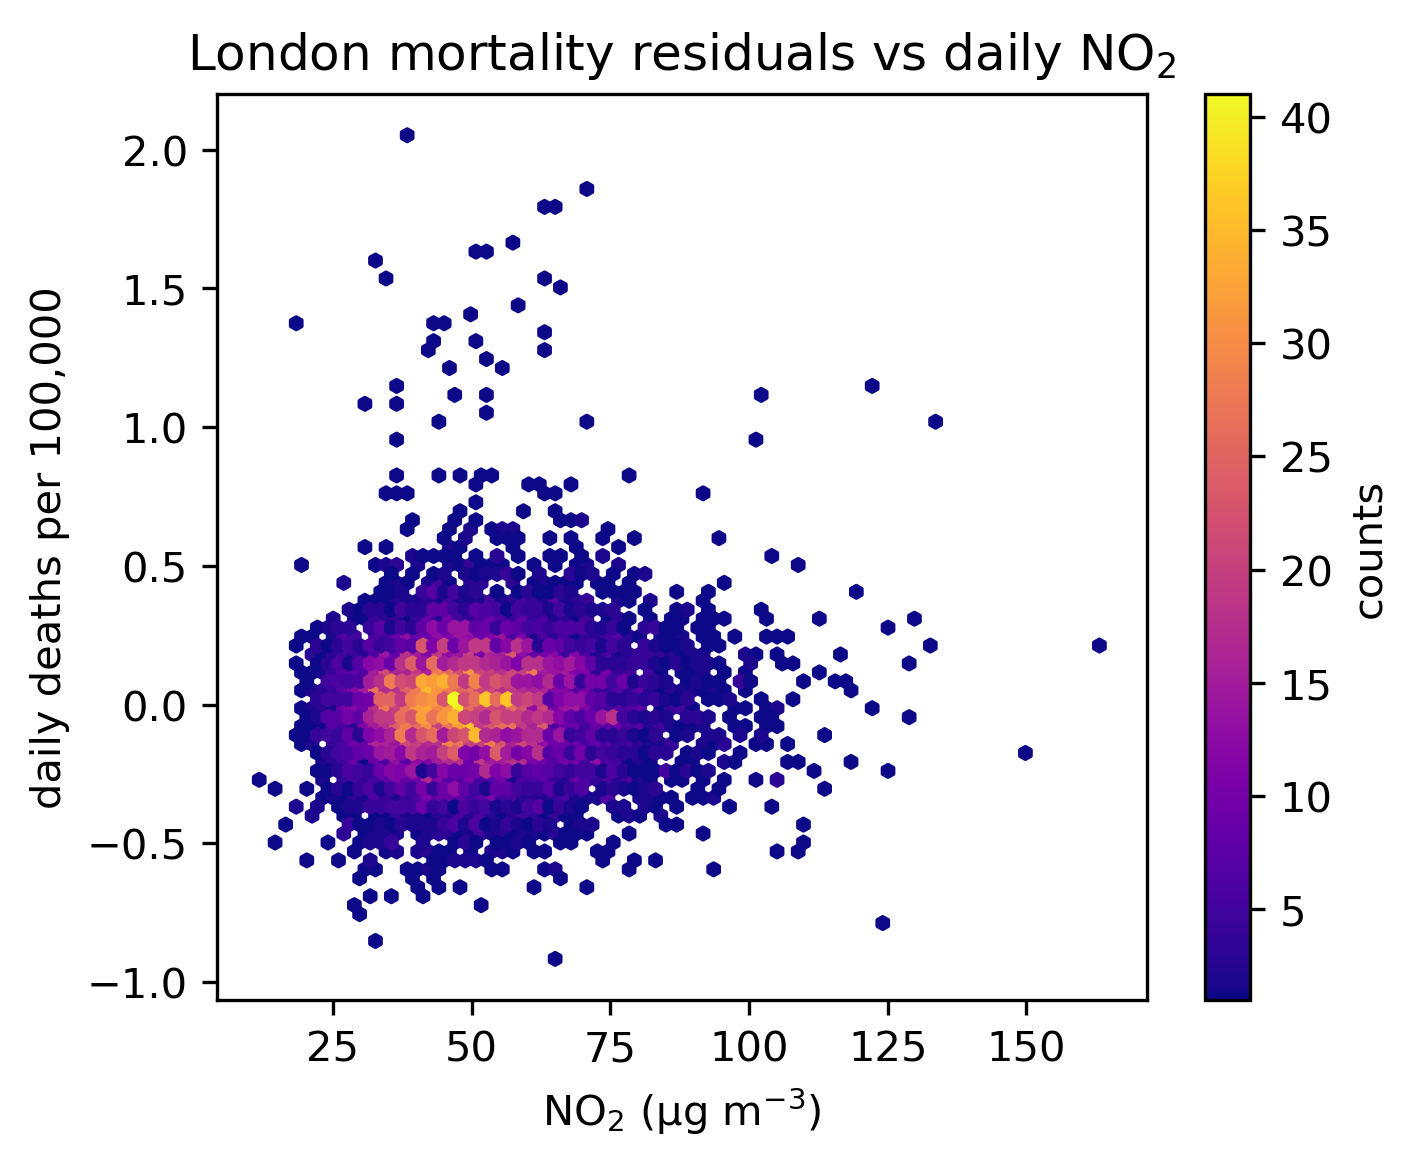

In [50]:
plot_correlation_hexbin(data_df.NO2_observed, data_df.mortality_residual, 
                        gridsize=80, 
                        xlabel="NO$_2$ (µg m$^{-3}$)", ylabel="daily deaths per 100,000",
                        title="London mortality residuals vs daily NO$_2$")

### Mortality de-seasonalised vs NO2 observed
Remove the seasonal component of mortality (assume temperature predicts this).

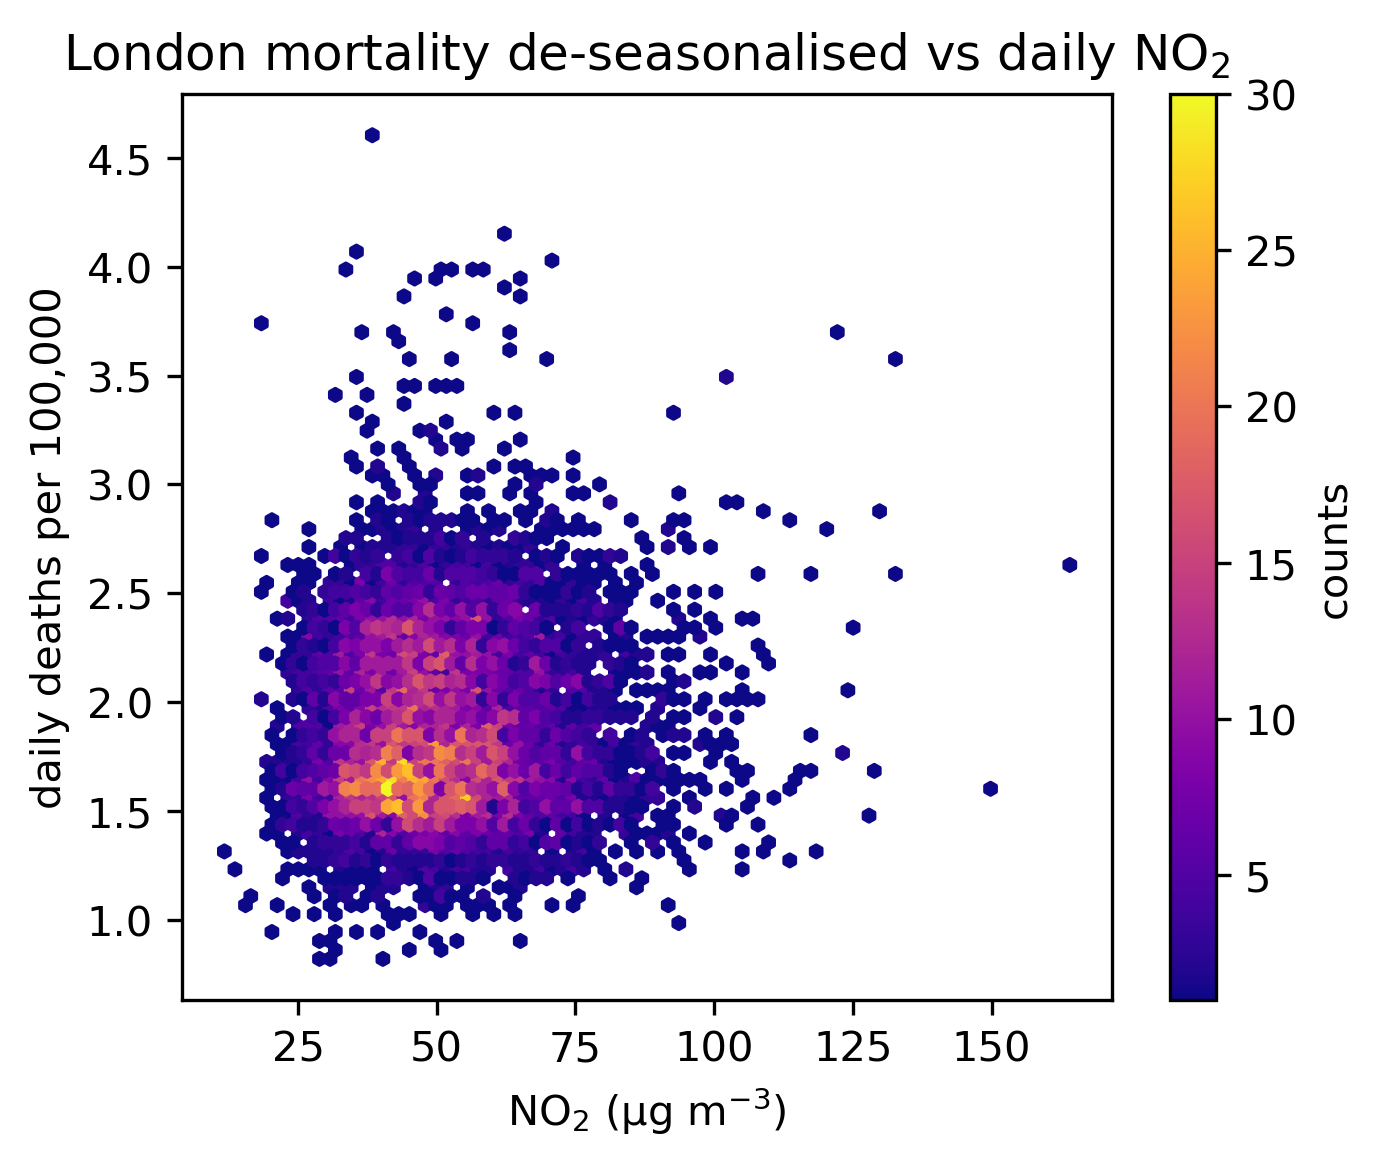

In [51]:
data_df = pd.DataFrame(decomp_dict["mortality"].trend + decomp_dict["mortality"].residual).join(decomp_dict["NO2"].observed).dropna()
data_df.columns = ["mortality_deseasonalised","NO2_observed"]
plot_correlation_hexbin(data_df.NO2_observed, data_df.mortality_deseasonalised, 
                        gridsize=80, 
                        xlabel="NO$_2$ (µg m$^{-3}$)", ylabel="daily deaths per 100,000",
                        title="London mortality de-seasonalised vs daily NO$_2$")

# 4 | Exploration of alternative NO2 statistics

In [10]:
mortality_df.shape

(13698, 2)

In [11]:
daily_dates = mortality_df.index

In [12]:
laqn_raw_df = NO2.read("laqn-raw")

wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact laqn-raw:latest, 1407.16MB. 198 files... Done. 0:0:0


In [13]:
laqn_raw_df.shape

(219169, 198)

<AxesSubplot:>

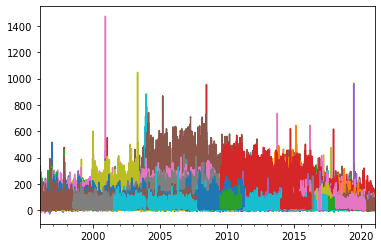

In [16]:
laqn_raw_df.plot(legend=False)

In [42]:
laqn_hourly_stats_df = pd.DataFrame({"regional_min": laqn_raw_df.quantile(0.05, axis=1), "regional_mean": laqn_raw_df.mean(axis=1), "regional_max": laqn_raw_df.quantile(0.95, axis=1)})

In [43]:
laqn_hourly_stats_df.shape

(219169, 3)

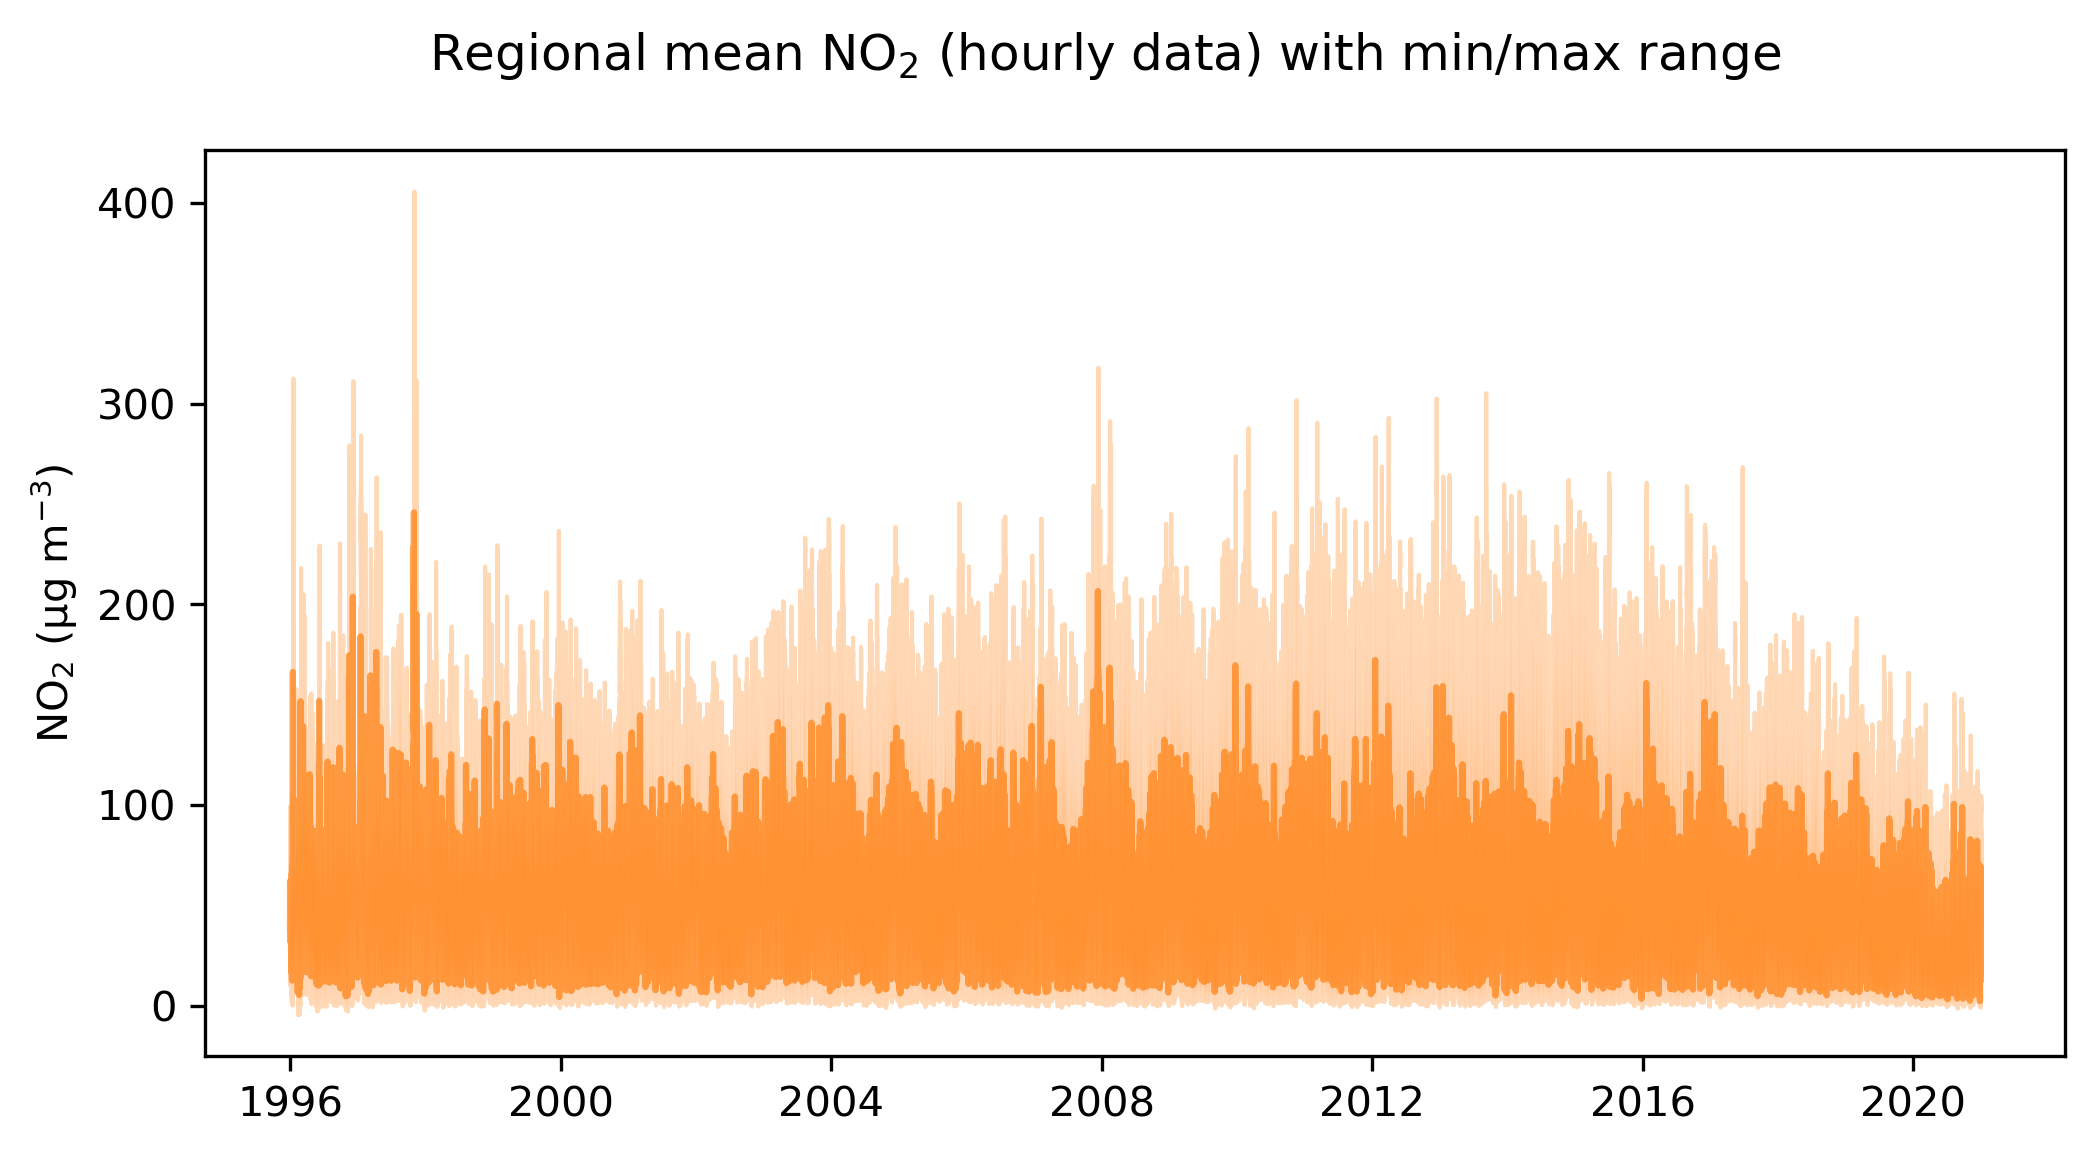

In [51]:
units = "NO$_2$ (µg m$^{-3}$)"
title = "Regional mean NO$_2$ (hourly data) with min/max range"

plt.figure(figsize=(8,4), dpi=300)
plt.plot(laqn_hourly_stats_df.index, laqn_hourly_stats_df.regional_mean, alpha=0.7, color="tab:orange")
plt.fill_between(laqn_hourly_stats_df.index, laqn_hourly_stats_df.regional_min, laqn_hourly_stats_df.regional_max, alpha=0.3, color="tab:orange")
# plt.legend()
plt.ylabel(units)
plt.suptitle(title)
plt.show()

### Daily minimum NO2

In [55]:
date_index = daily_dates

laqn_hourly_stats_df = laqn_hourly_stats_df.loc[laqn_hourly_stats_df.index < date_index.max()]
laqn_hourly_stats_df = laqn_hourly_stats_df.loc[laqn_hourly_stats_df.index > date_index.min()]
laqn_hourly_stats_df.shape

(201600, 3)

In [61]:
laqn_daily_stats_df = pd.DataFrame({"daily_min":laqn_hourly_stats_df.regional_mean.groupby(date_index[date_index.searchsorted(laqn_hourly_stats_df.index)]).min(),
                                   "daily_median":laqn_hourly_stats_df.regional_mean.groupby(date_index[date_index.searchsorted(laqn_hourly_stats_df.index)]).quantile(0.5),
                                   "daily_max":laqn_hourly_stats_df.regional_mean.groupby(date_index[date_index.searchsorted(laqn_hourly_stats_df.index)]).max()})

In [64]:
df = laqn_daily_stats_df.join(mortality_df)
df.shape

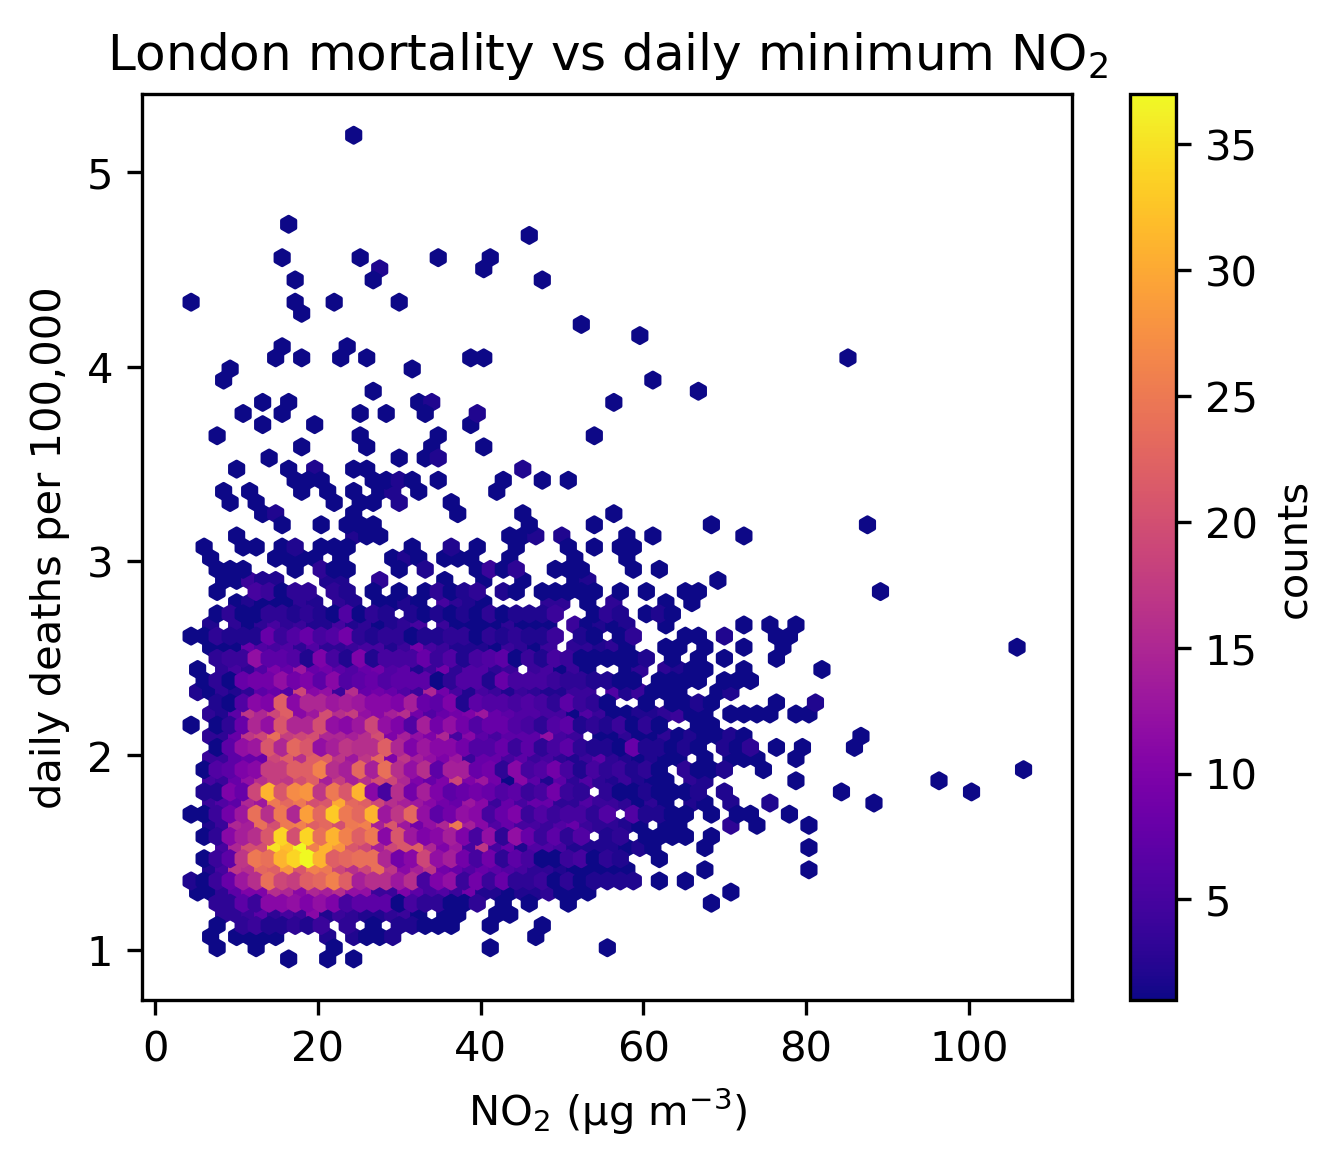

In [71]:
plot_correlation_hexbin(df.daily_min, df.deaths_per_100k, 
                        gridsize=65, 
                        xlabel="NO$_2$ (µg m$^{-3}$)", ylabel="daily deaths per 100,000",
                        title="London mortality vs daily minimum NO$_2$")

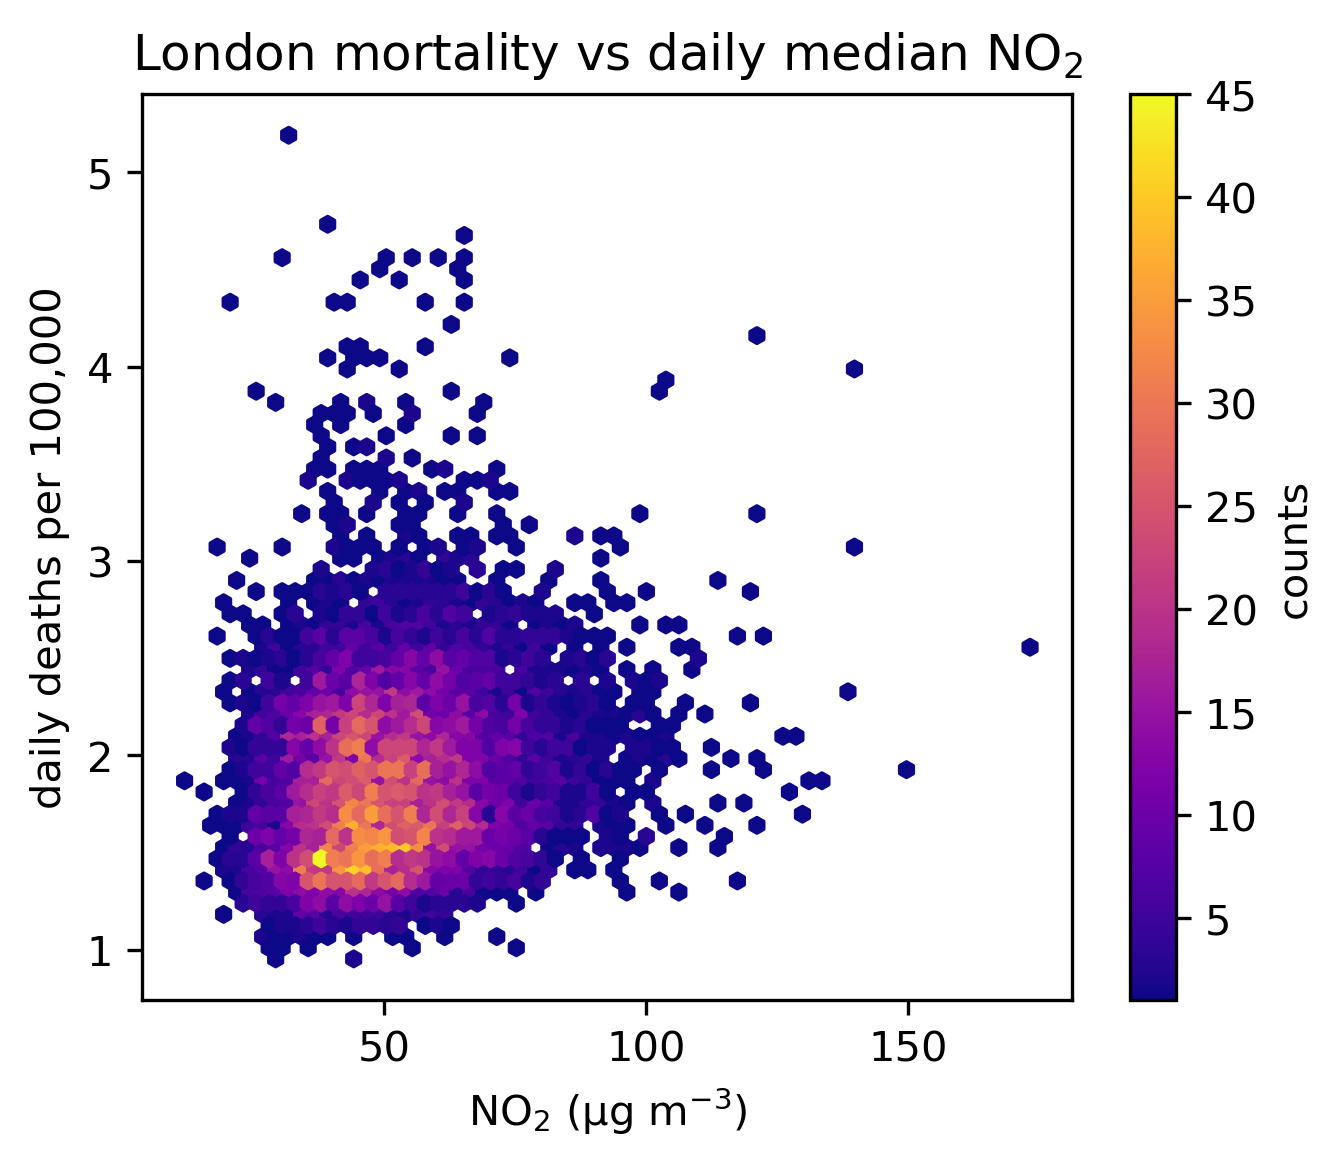

In [72]:
plot_correlation_hexbin(df.daily_median, df.deaths_per_100k, 
                        gridsize=65, 
                        xlabel="NO$_2$ (µg m$^{-3}$)", ylabel="daily deaths per 100,000",
                        title="London mortality vs daily median NO$_2$")

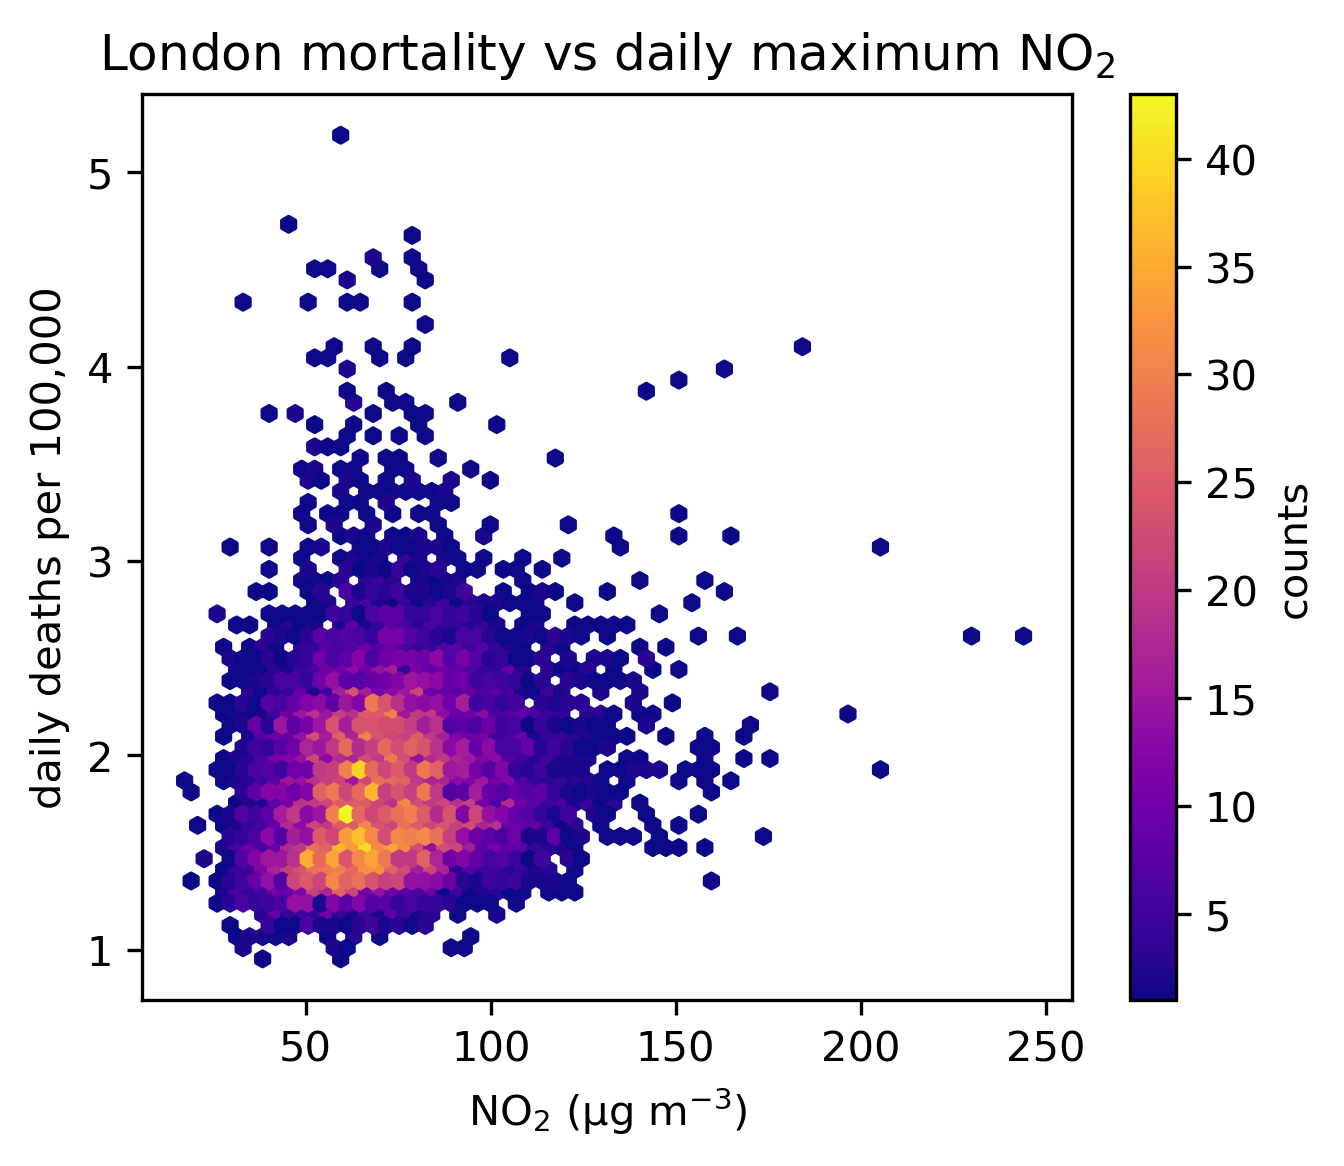

In [73]:
plot_correlation_hexbin(df.daily_max, df.deaths_per_100k, 
                        gridsize=65, 
                        xlabel="NO$_2$ (µg m$^{-3}$)", ylabel="daily deaths per 100,000",
                        title="London mortality vs daily maximum NO$_2$")